V3 : Co-kriging sur des données manquantes à la variable Y

In [3]:
import os
import timeit
import  matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import sklearn as sklearn
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from numba import jit
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error

In [4]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        if ii % 10000 == 0 :
            print("Iteration",ii,"/",n)
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                # Ajout de la directionalité 
                
                if (direction + theta_tolerance) < 360 and (direction - theta_tolerance) > 0  :
                    if ((tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance))) or ((tht >= (direction - theta_tolerance)+180) and (tht <= (direction + theta_tolerance)+180)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un index,
                    # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
        
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam

# Mise en place du cas synthétique

In [5]:
def fun_Primary(x,y,mu,sigma,size):
    field_z    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size))  # Fonction 2D test 
    
    return field_z

def fun_Secondary(x,y,mu,sigma,size):
    field_y    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size)) *np.exp(x/2)  # Fonction 2D test 

    
    return field_y


In [6]:
def function_circle(x,y,z,rmax = 20, roll = 3, delta = 1) :
    """
    Fonction qui choisi aléatoirement des zones de forme circulaire, renvoi un DataFrame 
    """
    ## Initialisation des constantes/ DataFrame
    df = pd.DataFrame()
    df["X"] = x.reshape(-1)
    df["Y"] = y.reshape(-1)
    df["Z"] = z.reshape(-1)
    mask_area = pd.DataFrame()
    mask_area["X"] = x.reshape(-1)
    mask_area["Y"] = y.reshape(-1)
    # Initialisation des matrices
    x_array  = np.empty(0)
    y_array  = np.empty(0)
    z_array  = np.empty(0)
    x0_array = np.empty(0)
    y0_array = np.empty(0)
    # rng, random generator 
    rng = np.random.default_rng()
    for i in np.arange(roll) : 
        selected_location =  rng.choice(mask_area.dropna(axis = 0))
        x0_array = np.append(x0_array,selected_location[0])
        y0_array = np.append(y0_array,selected_location[1])
        
        # Distance
        df['r'] = np.sqrt((x0_array[i]-df["X"])**2 + (y0_array[i]-df["Y"])**2)
        # Zone en dehors du cercle
        exp = "r < " + str(rmax * 2)
        mask_area.loc[df.query(exp).index.array] = np.nan
        
        # Zone situé dans le cercle 
        exp = "r < " + str(rmax)
        x_array = np.append(x_array,df.query(exp)["X"].values)
        y_array = np.append(y_array,df.query(exp)["Y"].values)
        z_array = np.append(z_array,df.query(exp)["Z"].values)
    
    df = pd.DataFrame()
    df["X"] = x_array
    df["Y"] = y_array
    df["original_y"] = z_array
    df.sort_values(by = ["X","Y"],ascending=False)
    df = df.dropna(axis = 0)
    df["Secondary"] = (df["original_y"] - df["original_y"].mean()) / df["original_y"].std()
    
 
    return df, x0_array, y0_array

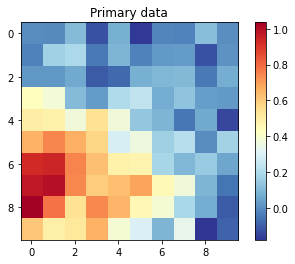

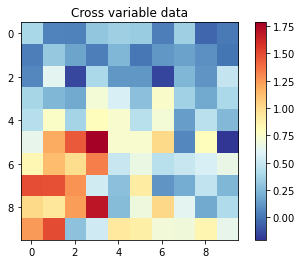

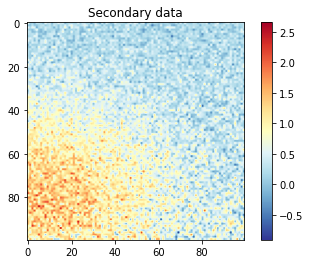

In [7]:
# Primary Data générées (Z)
x_original,y_original = np.mgrid[0:0.5 * np.pi:10j,0:0.5 * np.pi:10j]
# Secondary Data générées (Y)
xx_original, yy_original = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
# coordinates from 1 -> 100 
xx_z, yy_z  = np.mgrid[0:100:10, 0:100:10]
xx_y, yy_y = np.mgrid[0:100, 0:100]

# Setup Random Noise
np.random.seed(21)
mu_z, sigma_z = 0, 0.1
mu_y, sigma_y = 0.2, 0.2

#Primary Data
_field_z    = fun_Primary(x_original,y_original,mu_z,sigma_z,size = 10)
_field_zy   = fun_Secondary(x_original,y_original,mu = mu_y,sigma = sigma_y,size = 10) 


#Secondary Data
_field_y   = fun_Secondary(xx_original,yy_original,mu = mu_y,sigma = sigma_y,size = 100)

# Quick view 
figg = plt.imshow(_field_z, cmap='RdYlBu_r')
plt.title('Primary data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_zy, cmap='RdYlBu_r')
plt.title('Cross variable data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_y, cmap='RdYlBu_r')
plt.title('Secondary data')
plt.colorbar(figg)



In [8]:
# Conversion en dataframe
Primary = pd.DataFrame()
Primary["X"] = xx_z.reshape(-1)
Primary["Y"] = yy_z.reshape(-1)
Primary["original_z"] = _field_z.reshape(-1)
Primary["original_zy"] = np.nan
original_std_z = Primary["original_z"].std()
original_mean_z = Primary["original_z"].mean()
Primary["Primary"] = (Primary["original_z"] - Primary["original_z"].mean()) / Primary["original_z"].std()
Primary["Secondary"] = np.nan

In [9]:
rmax = 20
np.random.seed(3)
Secondary, x0_array, y0_array = function_circle(xx_y,yy_y,_field_y,rmax,roll = 5)
for x,y,zy_value in zip(Secondary["X"].values,Secondary["Y"].values,Secondary["original_y"]) :
    exp = "X == " + str(x) + " and Y == " + str(y)
    index = Primary.query(exp).index.array
    Primary.loc[index,'original_zy'] = zy_value
Primary["Secondary"] = (Primary["original_zy"] - Primary["original_zy"].mean()) / Primary["original_zy"].std()

In [16]:
Primary

,X,Y,original_z,original_zy,Primary,Secondary
0,0,0,-0.005196,NaN,-0.869635,NaN
1,0,10,-0.011120,NaN,-0.888949,NaN
2,0,20,0.104180,NaN,-0.512981,NaN
3,0,30,-0.125674,NaN,-1.262488,NaN
4,0,40,0.074539,0.512144,-0.609634,-0.093942
...,...,...,...,...,...,...
95,90,50,0.295602,NaN,0.111209,NaN
96,90,60,0.086673,0.997109,-0.570067,1.088564
97,90,70,0.333307,0.632736,0.234156,0.200101
98,90,80,-0.179504,-0.070359,-1.438017,-1.514281


In [19]:
Primary_dropna

,X,Y,original_z,original_zy,Primary,Secondary
4,0,40,0.074539,0.512144,-0.609634,-0.093942
5,0,50,-0.171105,0.421872,-1.410631,-0.314058
6,0,60,-0.020586,0.001477,-0.919819,-1.339121
7,0,70,-0.023457,0.443835,-0.929179,-0.260503
14,10,40,0.087065,0.408231,-0.568788,-0.347319
15,10,50,-0.032227,0.277046,-0.957778,-0.667191
16,10,60,0.023849,0.160386,-0.774925,-0.951648
17,10,70,0.029286,0.241104,-0.757195,-0.754829
20,20,0,0.015360,0.420198,-0.802604,-0.318139
21,20,10,0.018944,0.461307,-0.790918,-0.217900


In [23]:
corr

0.5029093237175792

C:\Users\Alexandre\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Alexandre\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


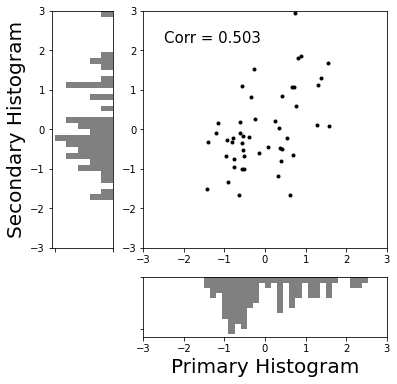

In [24]:
# Set up the axes with gridspec
Primary_dropna = Primary.dropna(axis = 0)
corr = np.corrcoef(Primary_dropna["Primary"], Primary_dropna["Secondary"])[0, 1]
vlim = (-3, 3)
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(Primary["Primary"], Primary["Secondary"], "ok", markersize=3)
main_ax.set_xlim(vlim)
main_ax.set_ylim(vlim)
main_ax.text(-2.5, 2.2,
    "Corr = {0:.3f}".format(
        corr
    ),
    size=15
)

# histogram on the attached axes
x_hist.hist(
    Primary["Primary"],
    40,
    histtype="stepfilled",
    label="Primary",
    orientation="vertical",
    color="gray",
    range=vlim,
)
x_hist.set_xlabel("Primary Histogram", size=20)
x_hist.invert_yaxis()


y_hist.hist(
    Primary["Secondary"],
    40,
    histtype="stepfilled",
    orientation="horizontal",
    color="gray",
    range=vlim,
)
y_hist.set_ylabel("Secondary Histogram", size=20)
y_hist.invert_xaxis()


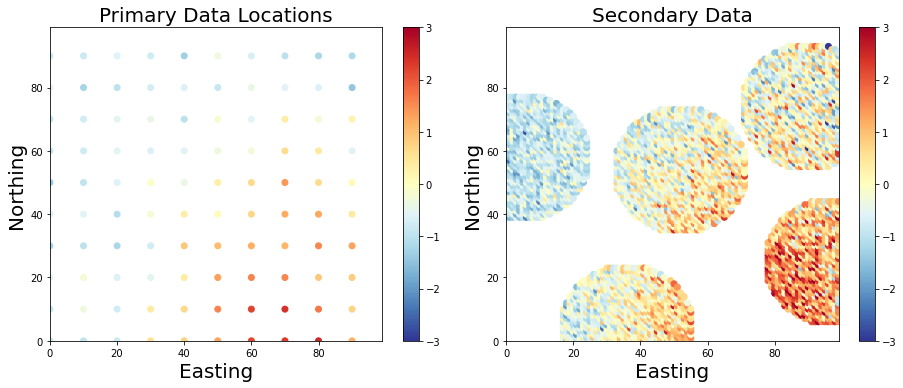

In [25]:
f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
img0 = ax[0].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)

img1 = ax[1].scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
ax[1].set_title("Secondary Data", size=20)
f.colorbar(img0, ax=ax[0])
f.colorbar(img1, ax=ax[1])
plt.tight_layout()

ax[0].set_xlim([xx_y.min(),xx_y.max()])
ax[0].set_ylim([yy_y.min(),yy_y.max()])
ax[1].set_xlim([xx_y.min(),xx_y.max()])
ax[1].set_ylim([yy_y.min(),yy_y.max()])
plt.show()


# Variogrammes

## Secondary 

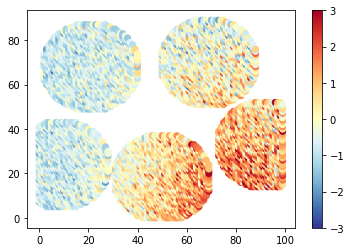

In [147]:
img1 = plt.scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                   vmin = -3,vmax = 3,cmap = "RdYlBu_r")
plt.colorbar(img1)

In [148]:
X = Secondary["X"].astype(float).values
Y = Secondary["Y"].astype(float).values
Z = Secondary["Secondary"].astype(float).values
original_std_y = Secondary["original_y"].std()
original_mean_y = Secondary["original_y"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 5620
size Y : 5620
size Z : 5620


In [149]:
L=(max(X)-min(X))*1/2 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 1.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 99.0  	 Distance maximale retenue : 49.5
nlag : 49


In [150]:
direction = [0,45,90,135] 
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 5620
direction done : 0
RUN TIME : 2.62689969999974
Iteration 0 / 5620
direction done : 45
RUN TIME : 0.4731258000001617
Iteration 0 / 5620
direction done : 90
RUN TIME : 0.4592982000003758
Iteration 0 / 5620
direction done : 135
RUN TIME : 0.45594419999997626


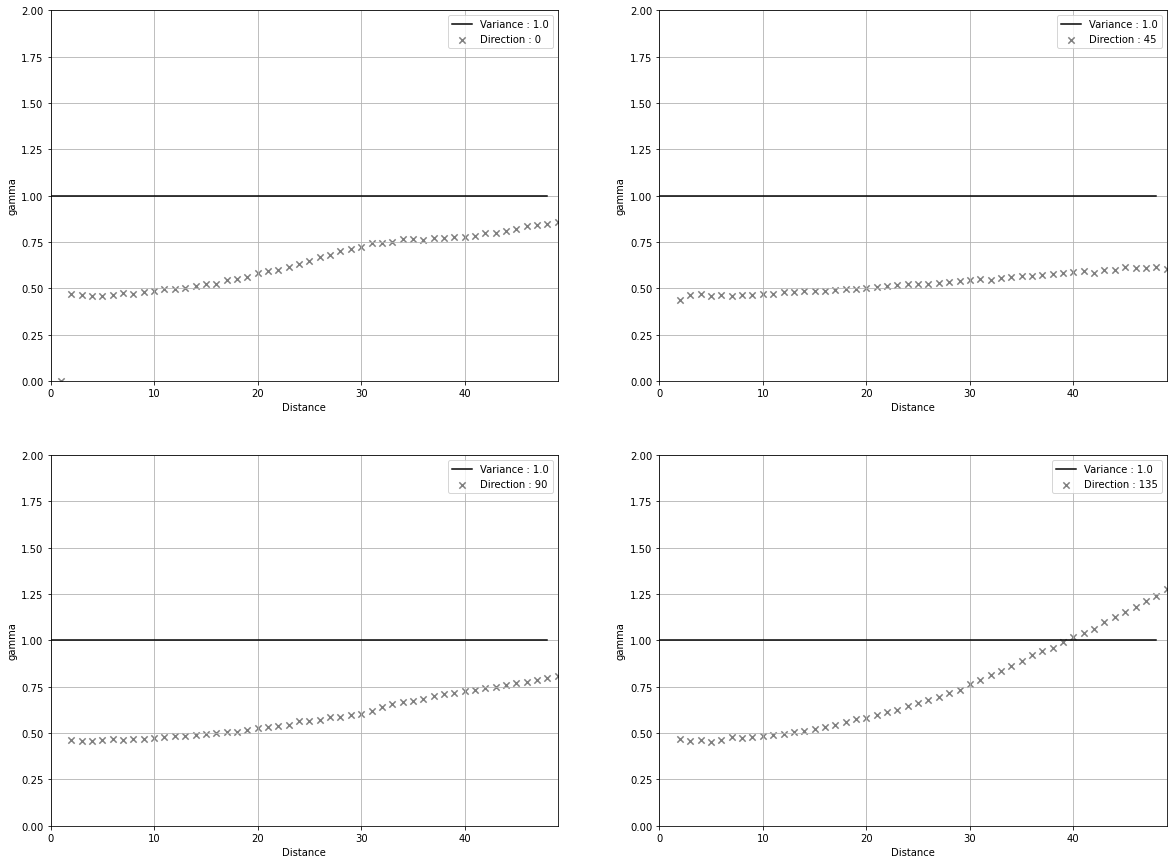

In [151]:
var_y = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_y
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_y))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [152]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [153]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2 = pd.DataFrame()
varc_2["Lag Distance"] = dist_array
varc_2["Number of Pairs"] = count_array
varc_2["Variogram Value"] = gam_array
varc_2["Variogram Index"] = index_array 
varc_2 = varc_2.loc[varc_2["Variogram Value"] != 0]
varc_2 = varc_2.dropna(axis = 0)

In [154]:
varc_2.head()

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,2.0,5426.0,0.469917,1.0
2,3.0,5232.0,0.464397,1.0
3,4.0,15010.0,0.456602,1.0
4,5.0,14438.0,0.459612,1.0
5,6.0,22968.0,0.464615,1.0


In [155]:
varc_2.head()

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,2.0,5426.0,0.469917,1.0
2,3.0,5232.0,0.464397,1.0
3,4.0,15010.0,0.456602,1.0
4,5.0,14438.0,0.459612,1.0
5,6.0,22968.0,0.464615,1.0


In [28]:
#Secondary.to_csv("cas_synthetique.csv")

## Primary 

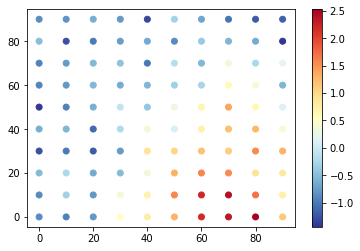

In [27]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [158]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Primary"].astype(float).values
original_std_y = Primary["original_z"].std()
original_mean_y = Primary["original_z"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 100
size Y : 100
size Z : 100


#### estimation de la distance maximale à retenir

In [159]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 127.27922061357856


In [160]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 90.0  	 Distance maximale retenue : 60.0
nlag : 6


In [161]:
direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 100
direction done : 0
RUN TIME : 0.0006227999992916011
Iteration 0 / 100
direction done : 45
RUN TIME : 0.0003724999996848055
Iteration 0 / 100
direction done : 90
RUN TIME : 0.0003698999998960062
Iteration 0 / 100
direction done : 135
RUN TIME : 0.0003657000006569433


In [26]:
var_z = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)+5])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

NameError: name 'Z' is not defined

In [163]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [164]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_1 = pd.DataFrame()
varc_1["Lag Distance"] = dist_array
varc_1["Number of Pairs"] = count_array
varc_1["Variogram Value"] = gam_array
varc_1["Variogram Index"] = index_array 
varc_1 = varc_1.loc[varc_1["Variogram Value"] != 0]
varc_1 = varc_1.dropna(axis = 0)

In [165]:
varc_1

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,90.0,0.161317,1.0
2,30.0,80.0,0.331954,1.0
3,40.0,196.0,0.555955,1.0
4,50.0,168.0,0.832189,1.0
5,60.0,220.0,1.152178,1.0
7,20.0,90.0,0.135233,2.0
8,30.0,80.0,0.238507,2.0
9,40.0,196.0,0.415188,2.0
10,50.0,168.0,0.630162,2.0
11,60.0,220.0,0.918280,2.0


In [166]:
Primary.to_csv("./cas synthetique/cas_synthetique_primary.csv")

## Cross 

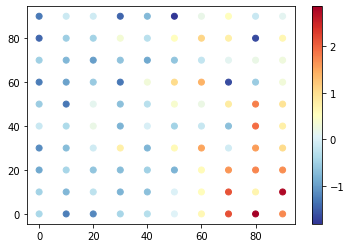

In [167]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Secondary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [168]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Secondary"].astype(float).values
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 100
size Y : 100
size Z : 100


#### estimation de la distance maximale à retenir

In [169]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 127.27922061357856


In [170]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 90.0  	 Distance maximale retenue : 60.0
nlag : 6


In [171]:
direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 100
direction done : 0
RUN TIME : 0.0009780000000318978
Iteration 0 / 100
direction done : 45
RUN TIME : 0.0007373999997071223
Iteration 0 / 100
direction done : 90
RUN TIME : 0.005404200000157289
Iteration 0 / 100
direction done : 135
RUN TIME : 0.0025415999998585903


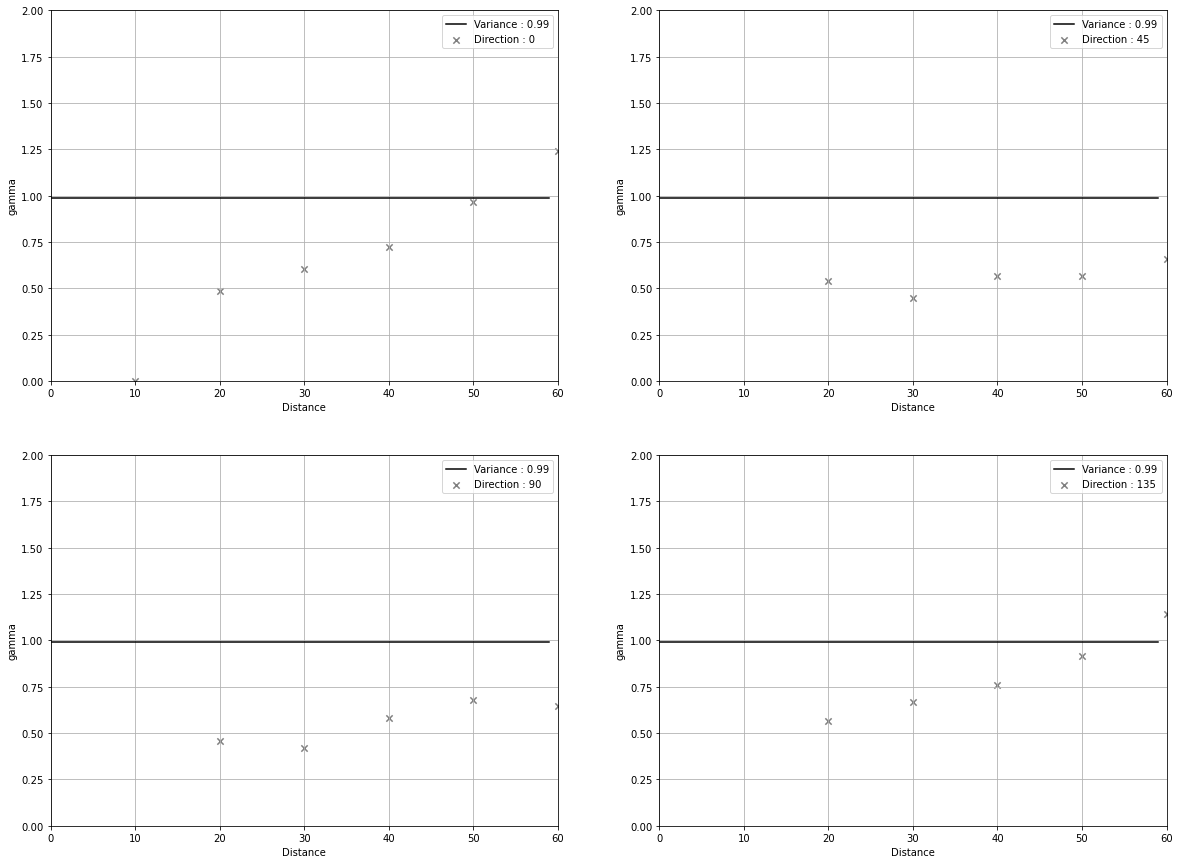

In [172]:
var_z = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [173]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [174]:
for direction in dist :
    if direction == 0 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 90 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_3 = pd.DataFrame()
varc_3["Lag Distance"] = dist_array
varc_3["Number of Pairs"] = count_array
varc_3["Variogram Value"] = gam_array
varc_3["Variogram Index"] = index_array 
varc_3 = varc_3.loc[varc_3["Variogram Value"] != 0]
varc_3 = varc_3.dropna(axis = 0)

In [175]:
varc_3

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,90.0,0.488312,1.0
2,30.0,80.0,0.606682,1.0
3,40.0,196.0,0.725446,1.0
4,50.0,168.0,0.963624,1.0
5,60.0,220.0,1.241096,1.0
7,20.0,90.0,0.457598,2.0
8,30.0,80.0,0.417588,2.0
9,40.0,196.0,0.583961,2.0
10,50.0,168.0,0.680239,2.0
11,60.0,220.0,0.648126,2.0


# Correlogramme Model

In [176]:
def covar(t, d, r):
    h = d / r
    if t == 1:  # Spherical
        c = (1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = (np.exp(-3 * h))
    elif t == 3:  # Gaussian
        c = (np.exp(-3 * np.square(h)))
    return c

In [177]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

In [178]:
## Define some matrices for storing variogram values
LENGTH = 150
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
Sill_vals = [1,1,corr] ## !!

### Plottting labels 
colors = ["Red", "Green","Blue"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]

Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram"]

labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]

Cross_ones = np.zeros(shape=(101))


## Primary

In [179]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,dict_C_Z,nstruct = 1,Azimuth = 0):
    C = []
    #nstruct = 1
    vtype = dict_C_Z["vtype"]
    a_max = dict_C_Z["a_max"]
    a_min = dict_C_Z["a_min"] 
    cc = dict_C_Z["cc"]
    #Azimuth = 45
    c = 0
    #print(vtype,a_max,a_min,cc)
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i] 
    return c

In [180]:
def optimize_RMSE_Z_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_z_0 = [x[0]]         # range
        a_min_z_0 = [x[1]]
        cc_z_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_z_0 = x[0::3]        # range
        a_min_z_0 = x[1::3]
        cc_z_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_primary_0 = {"a_max" : a_max_z_0
                ,"a_min" : a_min_z_0
                ,"cc" : cc_z_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_primary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k, dict_primary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [181]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_z_0 = np.array([80])
a_min_z_0 = np.array([80])
cc_z_0    = np.array([0.8])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_1, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_z_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_z_0[i]
    b = a_min_z_0[i]
    c = cc_z_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,2]]
if nstruct > 1 :
    Bounds *=  len(a_max_z_0)


# Minimize
Z_model = minimize(optimize_RMSE_Z_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(Z_model)

a_max_z = [float("{:.0f}".format(x)) for x in Z_model.x[0::3]]
a_min_z = [float("{:.0f}".format(x)) for x in Z_model.x[1::3]]
cc_z = [float("{:.2f}".format(x)) for x in Z_model.x[2::3]]

dict_primary = {"a_max" : a_max_z
                ,"a_min" : a_min_z
                ,"cc" : cc_z
                ,"vtype" : MODEL_value,
                "nstruct" : nstruct
}

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898173379460488, 0.29751595204620346] 

{'a_max': [79.99951556364381], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.2389828379396762, 0.29751595204620346] 

{'a_max': [80.00048443635619], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898062968538267, 0.29751595204620346] 

{'a_max': [80.0], 'a_min': [79.99951556364381], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898173379460488, 0.29751802453703796] 

{'a_max': [80.0], 'a_min': [80.00048443635619], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898173379460488, 0.297513879578072] 

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.7999939445455476], 'vtype': [1]}
RMSE : [0.23898372787805744, 0.2975182101297338] 

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.8000060554544525], 'vtype': [1]}
RMSE : [0.23897973971767428, 0.2975136939641386] 

{'a_max': [80.00000084864242], 'a_min': [80.00000159292705], 'cc': [0.8000000464818076], 'vtype': [1]}
RMSE : [0.238981716553

RMSE : [0.10567353979335656, 0.08071521079233586] 

{'a_max': [72.59640377321813], 'a_min': [81.20578163826664], 'cc': [1.4843839885652028], 'vtype': [1]}
RMSE : [0.10567366394432444, 0.08071421457153492] 

{'a_max': [72.59640351589188], 'a_min': [81.20578184203015], 'cc': [1.4843750027082148], 'vtype': [1]}
RMSE : [0.10567360129872598, 0.08071471170810429] 

{'a_max': [72.59596391167698], 'a_min': [81.20578184203015], 'cc': [1.4843750027082148], 'vtype': [1]}
RMSE : [0.10567267567353245, 0.08071471170810429] 

{'a_max': [72.59684312010678], 'a_min': [81.20578184203015], 'cc': [1.4843750027082148], 'vtype': [1]}
RMSE : [0.10567452712276675, 0.08071471170810429] 

{'a_max': [72.59640351589188], 'a_min': [81.20529010411693], 'cc': [1.4843750027082148], 'vtype': [1]}
RMSE : [0.10567360129872598, 0.08071651553928637] 

{'a_max': [72.59640351589188], 'a_min': [81.20627357994337], 'cc': [1.4843750027082148], 'vtype': [1]}
RMSE : [0.10567360129872598, 0.08071290810304829] 

{'a_max': [72.5964

RMSE : [0.10485030332028414, 0.07257124505623902] 

{'a_max': [71.29378411226429], 'a_min': [85.61046572487679], 'cc': [1.46042231415682], 'vtype': [1]}
RMSE : [0.10484932169103982, 0.07257215518963098] 

{'a_max': [71.29378241127422], 'a_min': [85.61046708198194], 'cc': [1.460413493678315], 'vtype': [1]}
RMSE : [0.10484981109648048, 0.07257170115670651] 

{'a_max': [71.2933506950221], 'a_min': [85.61046708198194], 'cc': [1.460413493678315], 'vtype': [1]}
RMSE : [0.10484978824480634, 0.07257170115670651] 

{'a_max': [71.29421412752635], 'a_min': [85.61046708198194], 'cc': [1.460413493678315], 'vtype': [1]}
RMSE : [0.10484983415509509, 0.07257170115670651] 

{'a_max': [71.29378241127422], 'a_min': [85.60994867169788], 'cc': [1.460413493678315], 'vtype': [1]}
RMSE : [0.10484981109648048, 0.07257172328568293] 

{'a_max': [71.29378241127422], 'a_min': [85.610985492266], 'cc': [1.460413493678315], 'vtype': [1]}
RMSE : [0.10484981109648048, 0.07257167930275724] 

{'a_max': [71.29378241127422

RMSE : [0.10469039395726938, 0.07272414920357038] 

{'a_max': [71.18109161184339], 'a_min': [85.52673686709919], 'cc': [1.4632357945246537], 'vtype': [1]}
RMSE : [0.10469039364846566, 0.07272414920357038] 

{'a_max': [71.18195368477987], 'a_min': [85.52673686709919], 'cc': [1.4632357945246537], 'vtype': [1]}
RMSE : [0.104690394474007, 0.07272414920357038] 

{'a_max': [71.18152264831163], 'a_min': [85.52621896383963], 'cc': [1.4632357945246537], 'vtype': [1]}
RMSE : [0.10469039395726938, 0.07272415862659026] 

{'a_max': [71.18152264831163], 'a_min': [85.52725477035875], 'cc': [1.4632357945246537], 'vtype': [1]}
RMSE : [0.10469039395726938, 0.0727241400559136] 

{'a_max': [71.18152264831163], 'a_min': [85.52673686709919], 'cc': [1.4632269339669468], 'vtype': [1]}
RMSE : [0.10469088408622322, 0.07272366393629222] 

{'a_max': [71.18152264831163], 'a_min': [85.52673686709919], 'cc': [1.4632446550823606], 'vtype': [1]}
RMSE : [0.10468990391419075, 0.07272463465366463] 

{'a_max': [71.1845424

In [182]:
dict_primary

{'a_max': [71.0],
 'a_min': [86.0],
 'cc': [1.46],
 'vtype': array([1]),
 'nstruct': 1}

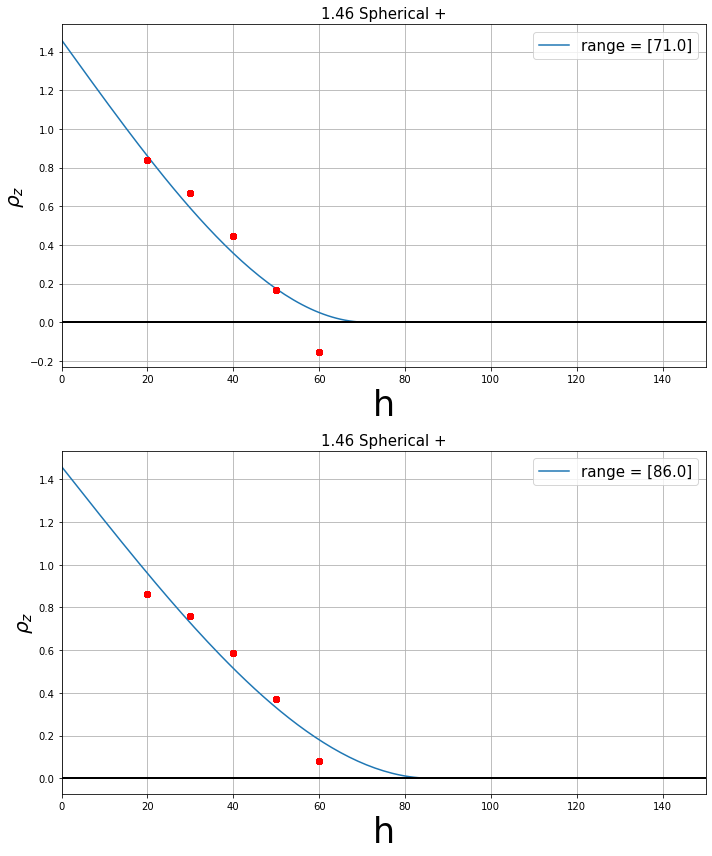

In [183]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = dict_primary["nstruct"]
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_primary["a_max"],
             1 : dict_primary["a_min"]}

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_primary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_primary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cz_True = np.zeros(shape=(LENGTH + 1))
for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type, dict_primary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [0]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, LENGTH))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Secondary

In [184]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,dict_C_Y,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_Y["vtype"]
    a_max = dict_C_Y["a_max"]
    a_min = dict_C_Y["a_min"] 
    cc = dict_C_Y["cc"]
    #Azimuth = 45
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1)  * cc[i]

    return c

In [185]:
def optimize_RMSE_Y_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_y_0 = [x[0]]         # range
        a_min_y_0 = [x[1]]
        cc_y_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_y_0 = x[0::3]        # range
        a_min_y_0 = x[1::3]
        cc_y_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_secondary_0 = {"a_max" : a_max_y_0
                ,"a_min" : a_min_y_0
                ,"cc" : cc_y_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_secondary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k, dict_secondary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [186]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_y_0 = np.array([50])
a_min_y_0 = np.array([72])
cc_y_0    = np.array([0.5])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_2, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_y_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_y_0[i]
    b = a_min_y_0[i]
    c = cc_y_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  len(a_max_y_0)


Y_model = minimize(optimize_RMSE_Y_model,x0,args = args,
                            method='TNC', jac = '3-point',# Minimize
                            bounds = Bounds,tol = 1e-9)


print(Y_model)

a_max_y = [float("{:.0f}".format(x)) for x in Y_model.x[0::3]]
a_min_y = [float("{:.0f}".format(x)) for x in Y_model.x[1::3]]
cc_y = [float("{:.2f}".format(x)) for x in Y_model.x[2::3]]

dict_secondary = {"a_max" : a_max_y
                ,"a_min" : a_min_y
                ,"cc" : cc_y
                ,"vtype" : MODEL_value
                  ,"nstruct" : nstruct
}

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17432191784127654, 0.15205817816858325] 

{'a_max': [49.99969722727738], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.1743231447230542, 0.15205817816858325] 

{'a_max': [50.00030277272262], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.1743206909614208, 0.15205817816858325] 

{'a_max': [50.0], 'a_min': [71.99956400727943], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17432191784127654, 0.1520594443838756] 

{'a_max': [50.0], 'a_min': [72.00043599272057], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17432191784127654, 0.15205691196522222] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.49999394454554763], 'vtype': [1]}
RMSE : [0.17432390704046916, 0.15206107208031683] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5000060554544524], 'vtype': [1]}
RMSE : [0.174319928664741, 0.15205528427932197] 

{'a_max': [50.00000194793836], 'a_min': [72.00000139609782], 'cc': [0.5000004307198738], 'vtype': [1]}
RMSE : [0.17432176845

RMSE : [0.09885578592395164, 0.09044428166207064] 

{'a_max': [83.26987518369677], 'a_min': [96.01997050832014], 'cc': [0.7743030560087818], 'vtype': [1]}
RMSE : [0.09885578592395164, 0.09044622106248976] 

{'a_max': [83.26987518369677], 'a_min': [96.0193890672831], 'cc': [0.7742970005543294], 'vtype': [1]}
RMSE : [0.09885218309782541, 0.0904415511629012] 

{'a_max': [83.26987518369677], 'a_min': [96.0193890672831], 'cc': [0.7743091114632342], 'vtype': [1]}
RMSE : [0.09885938875665694, 0.09044895156693718] 

{'a_max': [67.1681998380248], 'a_min': [84.39188643289233], 'cc': [0.755064215948007], 'vtype': [1]}
RMSE : [0.06687630413976928, 0.06783170276299585] 

{'a_max': [67.16779310405003], 'a_min': [84.39188643289233], 'cc': [0.755064215948007], 'vtype': [1]}
RMSE : [0.06687663108178167, 0.06783170276299585] 

{'a_max': [67.16860657199958], 'a_min': [84.39188643289233], 'cc': [0.755064215948007], 'vtype': [1]}
RMSE : [0.06687597725675985, 0.06783170276299585] 

{'a_max': [67.16819983802

RMSE : [0.02500473235837505, 0.03118553257072056] 

{'a_max': [85.14626047599194], 'a_min': [96.57208397956713], 'cc': [0.6313427670681351], 'vtype': [1]}
RMSE : [0.025005876476282572, 0.03118553257072056] 

{'a_max': [85.145744879812], 'a_min': [96.57149919171121], 'cc': [0.6313427670681351], 'vtype': [1]}
RMSE : [0.025005304377605175, 0.031186351567686635] 

{'a_max': [85.145744879812], 'a_min': [96.57266876742304], 'cc': [0.6313427670681351], 'vtype': [1]}
RMSE : [0.025005304377605175, 0.031184713628998172] 

{'a_max': [85.145744879812], 'a_min': [96.57208397956713], 'cc': [0.6313367116136827], 'vtype': [1]}
RMSE : [0.02500331117567852, 0.031186422830834434] 

{'a_max': [85.145744879812], 'a_min': [96.57208397956713], 'cc': [0.6313488225225875], 'vtype': [1]}
RMSE : [0.0250072979773489, 0.031184642784993732] 

{'a_max': [86.98204191515183], 'a_min': [106.45292190511887], 'cc': [0.599866766203148], 'vtype': [1]}
RMSE : [0.021516618091516865, 0.027416121362297603] 

{'a_max': [86.9815

{'a_max': [85.03070693750504], 'a_min': [108.80480551919376], 'cc': [0.611208928817374], 'vtype': [1]}
RMSE : [0.021155699541877394, 0.024550688275653532] 

{'a_max': [85.03070693750504], 'a_min': [108.80480551919376], 'cc': [0.6112210397262788], 'vtype': [1]}
RMSE : [0.021155952917383786, 0.024550435330689287] 

{'a_max': [85.0307069364641], 'a_min': [108.80480552308384], 'cc': [0.6112149842691272], 'vtype': [1]}
RMSE : [0.021155825901350806, 0.02455056145378376] 

{'a_max': [85.0301920368912], 'a_min': [108.80480552308384], 'cc': [0.6112149842691272], 'vtype': [1]}
RMSE : [0.02115582349703095, 0.02455056145378376] 

{'a_max': [85.031221836037], 'a_min': [108.80480552308384], 'cc': [0.6112149842691272], 'vtype': [1]}
RMSE : [0.021155828414789215, 0.02455056145378376] 

{'a_max': [85.0307069364641], 'a_min': [108.8041466605398], 'cc': [0.6112149842691272], 'vtype': [1]}
RMSE : [0.021155825901350806, 0.024550567187552604] 

{'a_max': [85.0307069364641], 'a_min': [108.80546438562789], 'c

RMSE : [0.02115419562796551, 0.024551860930435463] 

{'a_max': [85.03139467694751], 'a_min': [108.87969102750536], 'cc': [0.6111282162208381], 'vtype': [1]}
RMSE : [0.021154077766942985, 0.024551978309683812] 

{'a_max': [85.03139467694751], 'a_min': [108.87969102750536], 'cc': [0.611140327129743], 'vtype': [1]}
RMSE : [0.0211543141455787, 0.024551744180001032] 

{'a_max': [85.03143065228745], 'a_min': [108.88032869343581], 'cc': [0.6111339197915344], 'vtype': [1]}
RMSE : [0.021154188766717368, 0.024551867722756682] 

{'a_max': [85.03091574833212], 'a_min': [108.88032869343581], 'cc': [0.6111339197915344], 'vtype': [1]}
RMSE : [0.02115418873660056, 0.024551867722756682] 

{'a_max': [85.03194555624279], 'a_min': [108.88032869343581], 'cc': [0.6111339197915344], 'vtype': [1]}
RMSE : [0.021154188905956054, 0.024551867722756682] 

{'a_max': [85.03143065228745], 'a_min': [108.87966937356465], 'cc': [0.6111339197915344], 'vtype': [1]}
RMSE : [0.021154188766717368, 0.02455186769939772] 

{'a_

In [187]:
dict_secondary

{'a_max': [85.0],
 'a_min': [109.0],
 'cc': [0.61],
 'vtype': array([1]),
 'nstruct': 1}

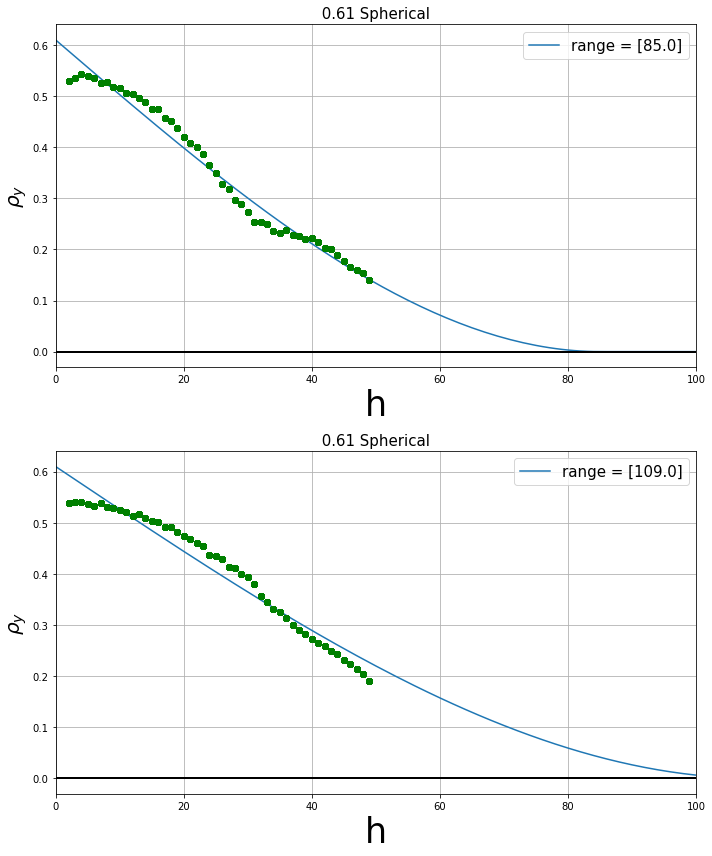

In [188]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = 1

MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_secondary["a_max"],
             1 : dict_secondary["a_min"]}

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_secondary["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_secondary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_secondary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h),varg_type, dict_secondary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [1]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Cross

In [189]:
def C_ZY(h1, h2, k,dict_C_ZY,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_ZY["vtype"]
    a_max = dict_C_ZY["a_max"]
    a_min = dict_C_ZY["a_min"] 
    cc = dict_C_ZY["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

In [190]:
def optimize_RMSE_ZY_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_zy_0 = [x[0]]         # range
        a_min_zy_0 = [x[1]]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = [args[3]]     # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_zy_0 = x[0::3]        # range
        a_min_zy_0 = x[1::3]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = args[3::]     # type de modèle
        nstruct = len(MODEL_value)  # nombre de couche
    
    dict_cross_0 = {"a_max" : a_max_zy_0
                ,"a_min" : a_min_zy_0
                ,"cc" : cc_zy_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_cross_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k, dict_cross_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [191]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0,1]
corr = float("{:.2f}".format(corr))
print("Coeff de correlation :", corr)

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_zy_0  = np.array([30])
a_min_zy_0  = np.array([30])
cc_zy_0     = [corr]
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_3, corr # variogram , Variance
nstruct = len(a_max_zy_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_zy_0[i]
    b = a_min_zy_0[i]
    c = cc_zy_0[i] # cc n'est pas à minimiser ici 
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[c,d])
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150]]
if nstruct > 1 :
    Bounds *=  len(a_max_zy_0)


# Minimize
ZY_model = minimize(optimize_RMSE_ZY_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(ZY_model)

a_max_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[0::3]]
a_min_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[1::3]]
cc_zy = [corr]

dict_cross = {"a_max" : a_max_zy
                ,"a_min" : a_min_zy
                ,"cc" : cc_zy
                ,"vtype" : MODEL_value
              ,"nstruct"  : nstruct
}

Coeff de correlation : 0.56
{'a_max': array([30.]), 'a_min': array([30.]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36234864212460666, 0.09322744939169397] 

{'a_max': array([29.99981834]), 'a_min': array([30.]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36234863040173354, 0.09322744939169397] 

{'a_max': array([30.00018166]), 'a_min': array([30.]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36234865385020354, 0.09322744939169397] 

{'a_max': array([30.]), 'a_min': array([29.99981834]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36234864212460666, 0.0932275279599073] 

{'a_max': array([30.]), 'a_min': array([30.00018166]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36234864212460666, 0.09322737082180851] 

{'a_max': array([29.99999997]), 'a_min': array([30.00000021]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36234864212261775, 0.09322744930237697] 

{'a_max': array([29.99981

RMSE : [0.36231355864532994, 0.08590769305130588] 

{'a_max': array([28.91869205]), 'a_min': array([40.73999023]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36231355864530795, 0.08590769308255565] 

{'a_max': array([28.91851693]), 'a_min': array([40.73999023]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36231355865217774, 0.08590769308255565] 

{'a_max': array([28.91886716]), 'a_min': array([40.73999023]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36231355864029746, 0.08590769308255565] 

{'a_max': array([28.91869205]), 'a_min': array([40.73974353]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36231355864530795, 0.0859076931288981] 

{'a_max': array([28.91869205]), 'a_min': array([40.74023693]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE : [0.36231355864530795, 0.08590769305100893] 

{'a_max': array([28.91883587]), 'a_min': array([40.74066189]), 'cc': [0.56], 'vtype': array([1.0], dtype=object)}
RMSE 

In [192]:
dict_cross

{'a_max': [29.0],
 'a_min': [41.0],
 'cc': [0.56],
 'vtype': array([1]),
 'nstruct': 1}

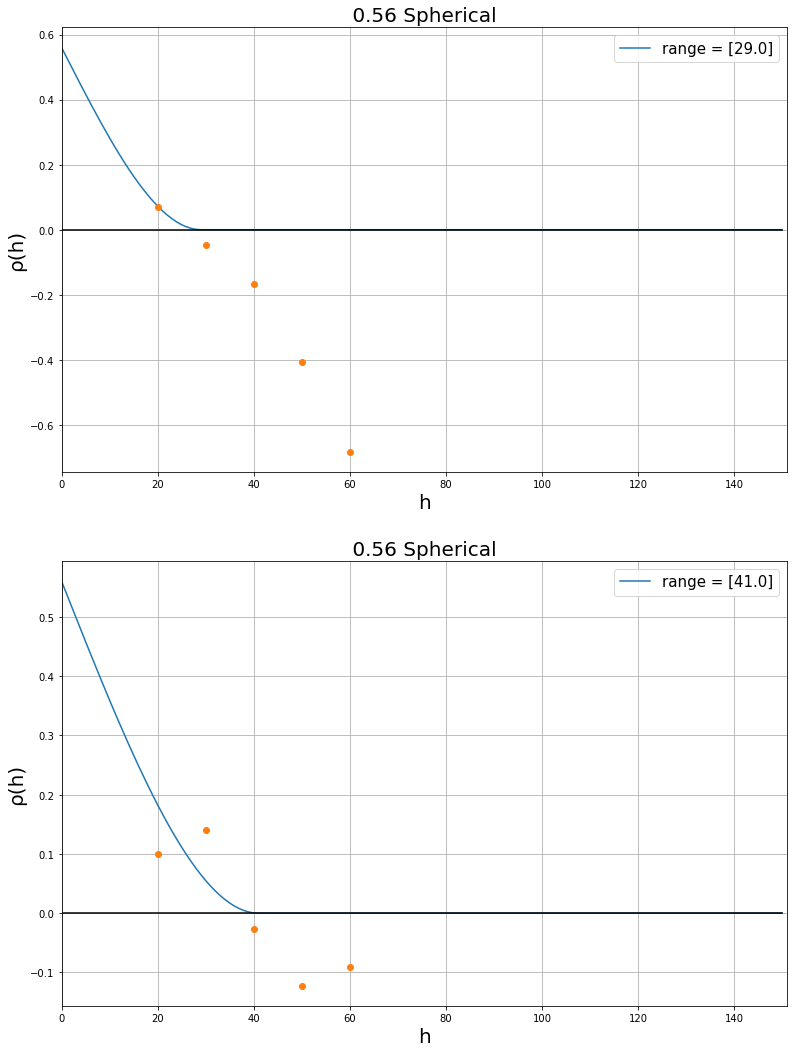

In [193]:
## Constantes de démarrage
varg_type = 2  # See Correlogram Functions
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_cross["a_max"],
             1 : dict_cross["a_min"]}

fig, axes = plt.subplots(2, 1, figsize=(13, 18))
czy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_cross["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_cross["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_cross["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1


for s in range(2) :

    for h in range(0, LENGTH + 1):
        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, 1)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in [2]: 
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)

        if (i + 1) <= 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (s + 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (s + 1)
                ],
                "o"
                )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, LENGTH + 1)
    #axes[k].set_ylim(-0.1, 1)
    axes[s].set_ylabel("\u03C1(h)", size=20)
    axes[s].set_xlabel("h", size=20)
    axes[s].set_title(TITLE,size=20)
    axes[s].legend(loc="best", prop={"size": 15})
    varg_type = varg_type + 1

    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

# Correlogram MM2 

### Scalling Correlogram 

In [194]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r (h1, h2, k, dict_C_r,nstruct = 1,Azimuth = 0 ):
    C = []
    vtype = dict_C_r["vtype"]
    a_max = dict_C_r["a_max"]
    a_min = dict_C_r["a_min"] 
    cc = dict_C_r["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### C_Z_MM2

In [195]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr,dict_secondary, dict_C_r ):
    
    return (C_Y_alternate(h1, h2, k,dict_secondary, nstruct = 1) * corr ** 2) + (
        (1 - corr ** 2) * C_r (h1, h2, k,dict_C_r,nstruct = 1 )
    )

In [196]:
def optimize_RMSE_scalling_correlogram(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On minimize ici la différence entre le correlogram généré C_Z_MII ( qui se base sur le correlogram Y) et
    le modèle de correlogram ce C_Z. Les modifications s'effectuent sur le correlogram C_r 
    """
    
    dict_secondary = args[0] # dictionnaire des valeurs du correlogram secondaire
    dict_primary   = args[1] # dictionnaire des valeurs du correlogram primaire
    corr  = args[2]
    RMSE = [] # Liste des RMSE
    
    Direction = ["Major", "Minor"] #Deux directions à additionner
    
    ## x0
    if len(x0) == 3 :
        a_max_r_0 = [x[0]]         # range
        a_min_r_0 = [x[1]]
        cc_r_0 = [x[2]]            # effet pépite
        MODEL_value = [args[3]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible.
        
        a_max_r_0 = x[0::3]        # range
        a_min_r_0 = x[1::3]
        cc_r_0 = x[2::3]           # effet pépite
        MODEL_value = args[3::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_scalling_0 = {"a_max" : a_max_r_0
                ,"a_min" : a_min_r_0
                ,"cc" : cc_r_0
                ,"vtype" : MODEL_value
                 }
    print(dict_scalling_0)
    for i,Dir in enumerate(Direction) :
        
        # Inititialisation des matrices
        cy = np.zeros(shape=(101))
        cr = np.zeros(shape=(101))
        cz_mm2 = np.zeros(shape=(101))
        cz = np.zeros(shape=(101))
        k = i + 2                # numéro de la direction 
        
        for h in range(0, 101):
            cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_secondary, nstruct = 1)

            cz[h] = C_Z_alternate(np.matrix(h), np.matrix(h),k,
                                  dict_primary, nstruct = 1)

            cr[h] = C_r(np.matrix(h), np.matrix(h), k,
                        dict_scalling_0,nstruct = 1 )

            cz_mm2[h] = C_Z_MM2(np.matrix(h), np.matrix(h), k, corr,dict_secondary, dict_scalling_0)

            RMSE.append(np.sqrt(mean_squared_error(cz,cz_mm2))) 
    return sum(RMSE)

In [197]:
print('-' * 30)
print("dict_primary :", dict_primary)
print("dict_secondary :", dict_secondary)
print("dict_cross :", dict_cross)

------------------------------
dict_primary : {'a_max': [71.0], 'a_min': [86.0], 'cc': [1.46], 'vtype': array([1]), 'nstruct': 1}
dict_secondary : {'a_max': [85.0], 'a_min': [109.0], 'cc': [0.61], 'vtype': array([1]), 'nstruct': 1}
dict_cross : {'a_max': [29.0], 'a_min': [41.0], 'cc': [0.56], 'vtype': array([1]), 'nstruct': 1}


In [198]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_r_0 = np.array([10])
a_min_r_0 = np.array([10])
cc_r_0    = np.array([2])
MODEL_value = np.array([MODEL_type["Spherical"]])
nstruct = len(a_max_r_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[dict_secondary,dict_primary,corr])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_r_0[i]
    b = a_min_r_0[i]
    c = cc_r_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  nstruct


# Minimize
scalling_model = minimize(optimize_RMSE_scalling_correlogram,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(scalling_model)

a_max_r = [float("{:.0f}".format(x)) for x in scalling_model.x[0::3]]
a_min_r = [float("{:.0f}".format(x)) for x in scalling_model.x[1::3]]
cc_r = [float("{:.2f}".format(x)) for x in scalling_model.x[2::3]]

dict_scalling = {"a_max" : a_max_r
                ,"a_min" : a_min_r
                ,"cc" : cc_r
                ,"vtype" : MODEL_value
}

{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [9.999939445455476], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.000060554544524], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [9.999939445455476], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.000060554544524], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [1.9999878890910952], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0000121109089046], 'vtype': [1]}
{'a_max': [10.00000261895245], 'a_min': [10.000002471090085], 'cc': [2.000000013391184], 'vtype': [1]}
{'a_max': [9.999942064392068], 'a_min': [10.000002471090085], 'cc': [2.000000013391184], 'vtype': [1]}
{'a_max': [10.000063173512833], 'a_min': [10.000002471090085], 'cc': [2.000000013391184], 'vtype': [1]}
{'a_max': [10.00000261895245], 'a_min': [9.999941916530597], 'cc': [2.000000013391184], 'vtype': [1]}
{'a_max': [10.00000261895245], 'a_min': [10.000063025649572], 'cc': [2

{'a_max': [63.32440369362453], 'a_min': [86.10367899478568], 'cc': [1.8213004380479263], 'vtype': [1]}
{'a_max': [63.32440369362453], 'a_min': [86.10367899478568], 'cc': [1.8213224957851892], 'vtype': [1]}
{'a_max': [62.74972890871966], 'a_min': [85.75149520687147], 'cc': [1.8378377151918697], 'vtype': [1]}
{'a_max': [62.74934893059435], 'a_min': [85.75149520687147], 'cc': [1.8378377151918697], 'vtype': [1]}
{'a_max': [62.75010888684497], 'a_min': [85.75149520687147], 'cc': [1.8378377151918697], 'vtype': [1]}
{'a_max': [62.74972890871966], 'a_min': [85.75097594259802], 'cc': [1.8378377151918697], 'vtype': [1]}
{'a_max': [62.74972890871966], 'a_min': [85.75201447114492], 'cc': [1.8378377151918697], 'vtype': [1]}
{'a_max': [62.74972890871966], 'a_min': [85.75149520687147], 'cc': [1.8378265862492944], 'vtype': [1]}
{'a_max': [62.74972890871966], 'a_min': [85.75149520687147], 'cc': [1.837848844134445], 'vtype': [1]}
{'a_max': [62.749730180812634], 'a_min': [85.75149455809125], 'cc': [1.837

{'a_max': [69.38552122030664], 'a_min': [82.7132282582653], 'cc': [1.8487179812131616], 'vtype': [1]}
{'a_max': [69.38636154712201], 'a_min': [82.7132282582653], 'cc': [1.8487179812131616], 'vtype': [1]}
{'a_max': [69.38594138371433], 'a_min': [82.71272739207897], 'cc': [1.8487179812131616], 'vtype': [1]}
{'a_max': [69.38594138371433], 'a_min': [82.71372912445163], 'cc': [1.8487179812131616], 'vtype': [1]}
{'a_max': [69.38594138371433], 'a_min': [82.7132282582653], 'cc': [1.848706786385631], 'vtype': [1]}
{'a_max': [69.38594138371433], 'a_min': [82.7132282582653], 'cc': [1.848729176040692], 'vtype': [1]}
{'a_max': [69.38594133058594], 'a_min': [82.71322868900087], 'cc': [1.8487179816786397], 'vtype': [1]}
{'a_max': [69.38552116717857], 'a_min': [82.71322868900087], 'cc': [1.8487179816786397], 'vtype': [1]}
{'a_max': [69.3863614939933], 'a_min': [82.71322868900087], 'cc': [1.8487179816786397], 'vtype': [1]}
{'a_max': [69.38594133058594], 'a_min': [82.71272782281193], 'cc': [1.8487179816

{'a_max': [68.66039986213659], 'a_min': [83.12907209938365], 'cc': [1.8491088443952002], 'vtype': [1]}
{'a_max': [68.66039986213659], 'a_min': [83.12856871812208], 'cc': [1.8490976472008154], 'vtype': [1]}
{'a_max': [68.66039986213659], 'a_min': [83.12856871812208], 'cc': [1.849120041589585], 'vtype': [1]}
{'a_max': [68.99548502405054], 'a_min': [83.1424814410808], 'cc': [1.8486710296906748], 'vtype': [1]}
{'a_max': [68.99506722503355], 'a_min': [83.1424814410808], 'cc': [1.8486710296906748], 'vtype': [1]}
{'a_max': [68.99590282306752], 'a_min': [83.1424814410808], 'cc': [1.8486710296906748], 'vtype': [1]}
{'a_max': [68.99548502405054], 'a_min': [83.14197797557138], 'cc': [1.8486710296906748], 'vtype': [1]}
{'a_max': [68.99548502405054], 'a_min': [83.14298490659023], 'cc': [1.8486710296906748], 'vtype': [1]}
{'a_max': [68.99548502405054], 'a_min': [83.1424814410808], 'cc': [1.848659835147457], 'vtype': [1]}
{'a_max': [68.99548502405054], 'a_min': [83.1424814410808], 'cc': [1.8486822242

{'a_max': [69.13288111937054], 'a_min': [83.12501974010853], 'cc': [1.849247658601774], 'vtype': [1]}
{'a_max': [69.13371838646613], 'a_min': [83.12501974010853], 'cc': [1.849247658601774], 'vtype': [1]}
{'a_max': [69.13329975291833], 'a_min': [83.12451638033764], 'cc': [1.849247658601774], 'vtype': [1]}
{'a_max': [69.13329975291833], 'a_min': [83.12552309987942], 'cc': [1.849247658601774], 'vtype': [1]}
{'a_max': [69.13329975291833], 'a_min': [83.12501974010853], 'cc': [1.8492364605668061], 'vtype': [1]}
{'a_max': [69.13329975291833], 'a_min': [83.12501974010853], 'cc': [1.849258856636742], 'vtype': [1]}
{'a_max': [69.13329975291498], 'a_min': [83.12501974010682], 'cc': [1.8492476586017939], 'vtype': [1]}
{'a_max': [69.13288111936718], 'a_min': [83.12501974010682], 'cc': [1.8492476586017939], 'vtype': [1]}
{'a_max': [69.13371838646277], 'a_min': [83.12501974010682], 'cc': [1.8492476586017939], 'vtype': [1]}
{'a_max': [69.13329975291498], 'a_min': [83.12451638033593], 'cc': [1.84924765

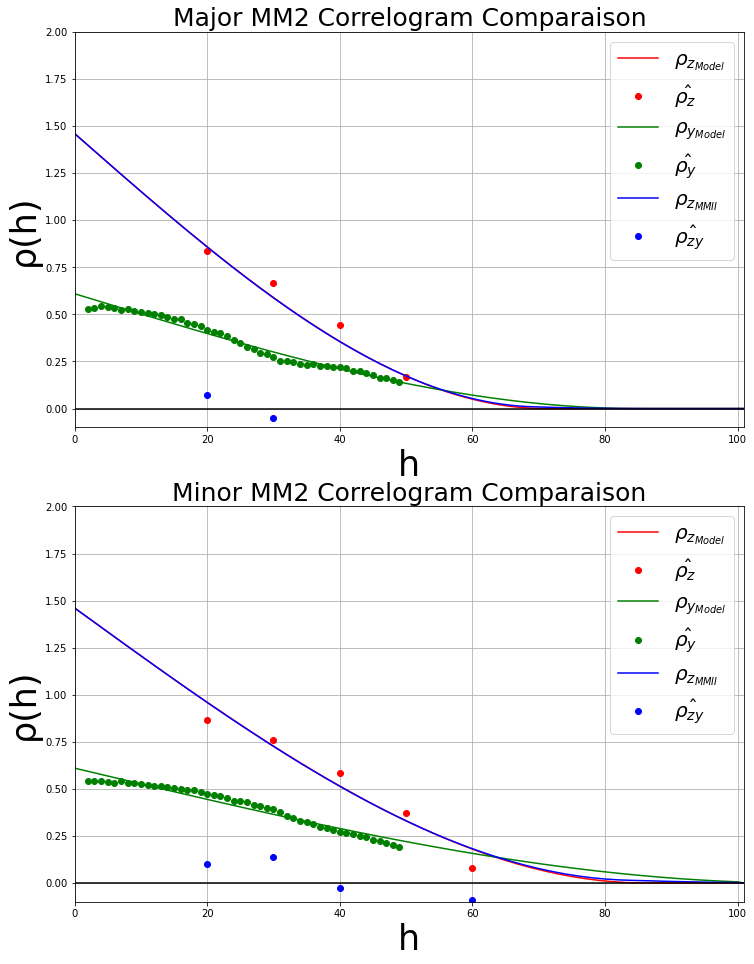

In [199]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{z_{MMII}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz_mm2 = np.zeros(shape=(LENGTH + 1))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary, nstruct = 1)

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary, nstruct = 1)

        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr,dict_secondary,dict_scalling )

        cr[h] = C_r (np.matrix(h), np.matrix(h), varg_type, dict_scalling,nstruct = 1 )

        H[h] = h
    MM_vargs = [cz_True, cy, cz]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" MM2 Correlogram Comparaison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

# LMC 

In [200]:
def optimize_RMSE_LMC_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On cherche à minimiser un seul modèle qui serait compatible avec les trois autres correlogrammes (pas les modèles) 
    """
    
    df_primary   = args[0] # DataFrame des valeurs primaire
    df_secondary = args[1] # DataFrame des valeurs secondaire
    df_cross     = args[2] # DataFrame des valeurs cross 
    sill_value_z = args[3]
    sill_value_y = args[4]
    corr         = args[5]
    nstruct      = args[-1]
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #Deux directions 
    ## x0
    if nstruct == 1 : # modèle à une couche
        a_max_0 = [x[0]]         # range
        a_min_0 = [x[1]]
        cc_0 = x[2::]            # effet pépite
        MODEL_value = [args[6]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible avec les données.
    
        a_max_0 = x[0:-3*nstruct:nstruct]     # range
        a_min_0 = x[1:-3*nstruct:nstruct]
        cc_0 = x[nstruct*nstruct::]   # effet pépite
        MODEL_value = args[6:6+nstruct]      # type de modèle
        
        ## Condition des sills, il faut c1 + c2 + .. = sill_value du correlogram
        for i,sill in zip([0,1,2],[sill_value_z,sill_value_y,corr]) :
            for c1,c2 in [cc_0[i::3]] :
                if c1 + c2 > sill :
                    cc_0[i+3] = sill - cc_0[i]
                    print(cc_0[i],cc_0[i+3])

    dict_model_LMC_z = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[0::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_y = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[1::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_zy = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[2::3]
                ,"vtype" : MODEL_value
                 }
    
    print("Z : ",dict_model_LMC_z,'\n Y :',dict_model_LMC_y,'\n ZY :',dict_model_LMC_zy)
    for i,Dir in enumerate(Direction) :
        k = i + 2
        MODEL_y  = []
        MODEL_z  = []
        MODEL_zy = []
        
        ### Correlogramme Y
        lag_value_y = df_secondary["Lag Distance"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_y = sill_value_y - df_secondary["Variogram Value"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        
        for h in lag_value_y:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_y,nstruct)
            MODEL_y.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_y,MODEL_y)))
        
        ### Correlogramme Z
        lag_value_z = df_primary["Lag Distance"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_z = sill_value_z - df_primary["Variogram Value"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_z:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_z,nstruct)
            MODEL_z.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_z,MODEL_z)))
        
        ## Correlogramme ZY
        lag_value_zy = df_cross["Lag Distance"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_zy = corr - df_cross["Variogram Value"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_zy:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_zy,nstruct)
            
            MODEL_zy.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_zy,MODEL_zy)))
    #print("RMSE value :",RMSE , " sum(RMSE) :",sum(RMSE),
    print("\n", "-" * 45)
    return sum(RMSE)

In [201]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_LMC_0  = np.array([40,70])
a_min_LMC_0  = np.array([40,70])
cc_LMC_0     = np.array([0.6,0.4,0.3,0.2,0.5,0.2]) # les cc sont en fin de liste
sill_value_z = Sill_vals[0]
sill_value_y = Sill_vals[1]
sill_value_zy = Sill_vals[2]

MODEL_value = np.array([MODEL_type["Spherical"],MODEL_type["Gaussien"]]  )
nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_LMC_0[i]
    b = a_min_LMC_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[d])
args = np.append(args,nstruct)
c = cc_LMC_0.tolist()
x0 = np.append(x0,c)
x0 = np.delete(x0,0)
args = np.delete(args,0)


# Boundaries 
Bounds = [[0,100],[0,100]] * nstruct
Bounds +=  [[0,1],[0,1],[0,corr]] * nstruct
      
# Minimize
LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                      "disp" : True})

Z :  {'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([0.6, 0.2]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([0.3, 0.2]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([39.99975778, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.6, 0.2]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([39.99975778, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([39.99975778, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.3, 0.2]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00024222, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.6, 0.2]

 ---------------------------------------------
Z :  {'a_max': array([40.00000027, 69.99999981]), 'a_min': array([40.00024263, 70.00000024]), 'cc': array([0.6       , 0.20000002]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000027, 69.99999981]), 'a_min': array([40.00024263, 70.00000024]), 'cc': array([0.39999998, 0.49999998]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000027, 69.99999981]), 'a_min': array([40.00024263, 70.00000024]), 'cc': array([0.3, 0.2]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00000027, 69.99957593]), 'a_min': array([40.00000042, 70.00000024]), 'cc': array([0.6       , 0.20000002]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000027, 69.99957593]), 'a_min': array([40.00000042, 70.00000024]), 'cc': array([0.39999998, 0.49999998]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000027, 69.99957593]), 'a_min':

 ---------------------------------------------
Z :  {'a_max': array([39.99976119, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.60000003, 0.2000001 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([39.99976119, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.39999993, 0.49999994]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([39.99976119, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.3       , 0.19999998]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00024563, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.60000003, 0.2000001 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00024563, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.39999993, 0.49999994]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00024563, 70.000001

 ---------------------------------------------
Z :  {'a_max': array([40.00000341, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.60000003, 0.2000001 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000341, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.39999993, 0.500006  ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000341, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.3       , 0.19999998]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00000341, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.60000003, 0.2000001 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000341, 70.00000173]), 'a_min': array([40.00000529, 70.00000466]), 'cc': array([0.39999993, 0.49999994]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000341, 70.000001


 ---------------------------------------------
Z :  {'a_max': array([46.1912512 , 65.63283126]), 'a_min': array([49.60777502, 75.54474491]), 'cc': array([0.70371641, 0.29628359]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([46.1912512 , 65.63283126]), 'a_min': array([49.60777502, 75.54474491]), 'cc': array([0.01148926, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([46.1912512 , 65.63283126]), 'a_min': array([49.60777502, 75.54474491]), 'cc': array([0.28182987, 0.10521405]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([46.1912512 , 65.63283126]), 'a_min': array([49.60777502, 75.54474491]), 'cc': array([0.70371641, 0.29627753]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([46.1912512 , 65.63283126]), 'a_min': array([49.60777502, 75.54474491]), 'cc': array([0.01148926, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([46.1912512 , 65.63283

 ZY : {'a_max': array([43.0956256 , 67.81641563]), 'a_min': array([44.80388751, 72.77237245]), 'cc': array([0.29091191, 0.15260703]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([43.0956256 , 67.81641563]), 'a_min': array([44.80388751, 72.77237245]), 'cc': array([0.6518582, 0.3481418]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([43.0956256 , 67.81641563]), 'a_min': array([44.80388751, 72.77237245]), 'cc': array([0.20573857, 0.25      ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([43.0956256 , 67.81641563]), 'a_min': array([44.80388751, 72.77237245]), 'cc': array([0.29091191, 0.15260703]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([43.0956256 , 67.81641563]), 'a_min': array([44.80388751, 72.77237245]), 'cc': array([0.6518582, 0.3481418]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([43.0956256 , 67.81641563])

 ---------------------------------------------
Z :  {'a_max': array([41.5478128 , 68.90820781]), 'a_min': array([42.40194375, 71.38618623]), 'cc': array([0.62592305, 0.31527909]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.5478128 , 68.90820781]), 'a_min': array([42.40194375, 71.38618623]), 'cc': array([0.30287231, 0.375     ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.5478128 , 68.90820781]), 'a_min': array([42.40194375, 71.38618623]), 'cc': array([0.29545595, 0.17630351]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([41.5478128 , 68.90820781]), 'a_min': array([42.40194375, 71.38618623]), 'cc': array([0.62593516, 0.31527909]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.5478128 , 68.90820781]), 'a_min': array([42.40194375, 71.38618623]), 'cc': array([0.30287231, 0.375     ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.5478128 , 68.908207

 Y : {'a_max': array([42.3217192 , 68.36189776]), 'a_min': array([43.60291563, 72.07927934]), 'cc': array([0.25430847, 0.3125    ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([42.3217192 , 68.36189776]), 'a_min': array([43.60291563, 72.07927934]), 'cc': array([0.29318393, 0.16445527]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([42.3217192 , 68.36272569]), 'a_min': array([43.60291563, 72.07927934]), 'cc': array([0.63889365, 0.36110635]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([42.3217192 , 68.36272569]), 'a_min': array([43.60291563, 72.07927934]), 'cc': array([0.25430847, 0.3125    ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([42.3217192 , 68.36272569]), 'a_min': array([43.60291563, 72.07927934]), 'cc': array([0.29318393, 0.16445527]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([42.3217192 , 68.362311


 ---------------------------------------------
Z :  {'a_max': array([41.934766  , 68.63525977]), 'a_min': array([43.00216929, 71.73273278]), 'cc': array([0.63241138, 0.34409886]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.934766  , 68.63525977]), 'a_min': array([43.00216929, 71.73273278]), 'cc': array([0.27859039, 0.34375   ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.934766  , 68.63525977]), 'a_min': array([43.00216929, 71.73273278]), 'cc': array([0.29431994, 0.17037939]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([41.934766  , 68.63525977]), 'a_min': array([43.00269009, 71.73273278]), 'cc': array([0.63241138, 0.34409886]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.934766  , 68.63525977]), 'a_min': array([43.00269009, 71.73273278]), 'cc': array([0.27859039, 0.34375   ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.934766  , 68.63525


 ---------------------------------------------
Z :  {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.63241139, 0.34409889]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.27859039, 0.34375   ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.29431994, 0.17037938]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([41.9345131 , 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.63241139, 0.34409889]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.9345131 , 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.27859039, 0.34375   ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.9345131 , 68.63526

 ---------------------------------------------
Z :  {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.63241139, 0.34409889]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.27859039, 0.34374394]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.29431994, 0.17037938]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.63241139, 0.34409889]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([41.93476703, 68.63526014]), 'a_min': array([43.00243048, 71.73273329]), 'cc': array([0.27859039, 0.34375605]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([41.93476703, 68.635260


 ---------------------------------------------
Z :  {'a_max': array([60.10309526, 75.19207881]), 'a_min': array([56.90172281, 80.58187666]), 'cc': array([0.75549834, 0.24450166]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([60.10309526, 75.19207881]), 'a_min': array([56.90172281, 80.58187666]), 'cc': array([0.2406074 , 0.26406366]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([60.10309526, 75.19207881]), 'a_min': array([56.90172281, 80.58187666]), 'cc': array([0.27293507, 0.06456136]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([60.10309526, 75.19207881]), 'a_min': array([56.90172281, 80.58187666]), 'cc': array([0.75549834, 0.2444956 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([60.10309526, 75.19207881]), 'a_min': array([56.90172281, 80.58187666]), 'cc': array([0.2406074 , 0.26406366]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([60.10309526, 75.19207


 ---------------------------------------------
Z :  {'a_max': array([60.10309556, 75.19207871]), 'a_min': array([56.9017232 , 80.58187672]), 'cc': array([0.75549834, 0.24450166]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([60.10309556, 75.19207871]), 'a_min': array([56.9017232 , 80.58187672]), 'cc': array([0.2406074 , 0.26406366]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([60.10309556, 75.19207871]), 'a_min': array([56.9017232 , 80.58187672]), 'cc': array([0.27292296, 0.06456135]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([60.10309556, 75.19207871]), 'a_min': array([56.9017232 , 80.58187672]), 'cc': array([0.75549834, 0.24450166]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([60.10309556, 75.19207871]), 'a_min': array([56.9017232 , 80.58187672]), 'cc': array([0.2406074 , 0.26406366]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([60.10309556, 75.19207


 ---------------------------------------------
Z :  {'a_max': array([60.10309542, 75.19207922]), 'a_min': array([56.90172465, 80.58187758]), 'cc': array([0.75549835, 0.24450165]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([60.10309542, 75.19207922]), 'a_min': array([56.90172465, 80.58187758]), 'cc': array([0.24061346, 0.26406366]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([60.10309542, 75.19207922]), 'a_min': array([56.90172465, 80.58187758]), 'cc': array([0.27292901, 0.06456135]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([60.10309542, 75.19207922]), 'a_min': array([56.90172465, 80.58187758]), 'cc': array([0.75549835, 0.24450165]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([60.10309542, 75.19207922]), 'a_min': array([56.90172465, 80.58187758]), 'cc': array([0.2406074 , 0.26406366]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([60.10309542, 75.19207

 ---------------------------------------------
Z :  {'a_max': array([63.89475067, 73.95975249]), 'a_min': array([61.89434929, 81.29323886]), 'cc': array([0.73789195, 0.26210805]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89475067, 73.95975249]), 'a_min': array([61.89434929, 81.29323886]), 'cc': array([0.26920371, 0.28071948]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89475067, 73.95975249]), 'a_min': array([61.89434929, 81.29323886]), 'cc': array([0.25457456, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([63.89475067, 73.95975249]), 'a_min': array([61.89434929, 81.2927466 ]), 'cc': array([0.73788589, 0.26210805]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89475067, 73.95975249]), 'a_min': array([61.89434929, 81.2927466 ]), 'cc': array([0.26920371, 0.28071948]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89475067, 73.959752


 ---------------------------------------------
Z :  {'a_max': array([63.89475082, 73.95975248]), 'a_min': array([61.89472461, 81.29274671]), 'cc': array([0.73789195, 0.26210805]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89475082, 73.95975248]), 'a_min': array([61.89472461, 81.29274671]), 'cc': array([0.26920371, 0.28071948]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89475082, 73.95975248]), 'a_min': array([61.89472461, 81.29274671]), 'cc': array([0.25457456, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([63.89475082, 73.95930462]), 'a_min': array([61.89434982, 81.29274671]), 'cc': array([0.73789195, 0.26210805]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89475082, 73.95930462]), 'a_min': array([61.89434982, 81.29274671]), 'cc': array([0.26920371, 0.28071948]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89475082, 73.95930


 ---------------------------------------------
Z :  {'a_max': array([63.89475111, 73.95975276]), 'a_min': array([61.89397538, 81.29274712]), 'cc': array([0.73789196, 0.26210804]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89475111, 73.95975276]), 'a_min': array([61.89397538, 81.29274712]), 'cc': array([0.26920371, 0.28071948]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89475111, 73.95975276]), 'a_min': array([61.89397538, 81.29274712]), 'cc': array([0.25457455, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([63.89475111, 73.95975276]), 'a_min': array([61.89472498, 81.29274712]), 'cc': array([0.73789196, 0.26210804]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89475111, 73.95975276]), 'a_min': array([61.89472498, 81.29274712]), 'cc': array([0.26920371, 0.28071948]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89475111, 73.95975

 ---------------------------------------------
Z :  {'a_max': array([63.89450538, 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([0.73789569, 0.26210431]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89450538, 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([0.26920412, 0.28071927]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89450538, 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([0.25457261, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([63.8952792 , 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([0.73789569, 0.26210431]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.8952792 , 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([0.26920412, 0.28071927]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.8952792 , 73.959834

 ZY : {'a_max': array([63.89489229, 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([2.54572610e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([63.89489229, 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([0.73789569, 0.26210431]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([63.89489229, 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([0.26920412, 0.28071927]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([63.89489229, 73.95983422]), 'a_min': array([61.89464423, 81.29291142]), 'cc': array([2.54572610e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([74.92213157, 80.39050964]), 'a_min': array([85.02235592, 94.24213703]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.92213157, 8

 Y : {'a_max': array([74.92213157, 80.39050964]), 'a_min': array([85.02235592, 94.24213703]), 'cc': array([0.29742311, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.92213157, 80.39050964]), 'a_min': array([85.02235592, 94.24213703]), 'cc': array([0.11301868, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([74.92213157, 80.39050964]), 'a_min': array([85.02235592, 94.24213703]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.92213157, 80.39050964]), 'a_min': array([85.02235592, 94.24213703]), 'cc': array([0.29742311, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.92213157, 80.39050964]), 'a_min': array([85.02235592, 94.24213703]), 'cc': array([0.11301263, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([74.92213157, 80.390509

Z :  {'a_max': array([74.92213159, 80.39050959]), 'a_min': array([85.02235654, 94.242137  ]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.92213159, 80.39050959]), 'a_min': array([85.02235654, 94.242137  ]), 'cc': array([0.29742311, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.92213159, 80.39050959]), 'a_min': array([85.02235654, 94.242137  ]), 'cc': array([0.11301263, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([74.92213159, 80.39050959]), 'a_min': array([85.02235654, 94.242137  ]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.92213159, 80.39050959]), 'a_min': array([85.02235654, 94.242137  ]), 'cc': array([0.29741705, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.92213159, 80.39050959]), 'a_min': array([85.02235654, 94.242137  ]), 'cc': array([


 ---------------------------------------------
Z :  {'a_max': array([74.9221319 , 80.39050955]), 'a_min': array([85.02235774, 94.24213708]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.9221319 , 80.39050955]), 'a_min': array([85.02235774, 94.24213708]), 'cc': array([0.29742311, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.9221319 , 80.39050955]), 'a_min': array([85.02235774, 94.24213708]), 'cc': array([0.11301263, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([74.9221319 , 80.39050955]), 'a_min': array([85.02235774, 94.24213708]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.9221319 , 80.39050955]), 'a_min': array([85.02235774, 94.24213708]), 'cc': array([0.29742311, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.9221319 , 80.39050

Z :  {'a_max': array([74.92213164, 80.39050961]), 'a_min': array([85.02287079, 94.24213703]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.92213164, 80.39050961]), 'a_min': array([85.02287079, 94.24213703]), 'cc': array([0.29742311, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.92213164, 80.39050961]), 'a_min': array([85.02287079, 94.24213703]), 'cc': array([0.11301263, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([74.92213164, 80.39002281]), 'a_min': array([85.02235594, 94.24213703]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([74.92213164, 80.39002281]), 'a_min': array([85.02235594, 94.24213703]), 'cc': array([0.29742311, 0.2657272 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([74.92213164, 80.39002281]), 'a_min': array([85.02235594, 94.24213703]), 'cc': array([0.11301263, 0.  

 ---------------------------------------------
Z :  {'a_max': array([78.98014968, 78.57317823]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.98014968, 78.57317823]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.98014968, 78.57317823]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.03425634, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([78.97967142, 78.57317823]), 'a_min': array([99.99939445, 94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967142, 78.57317823]), 'a_min': array([99.99939445, 94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.97967142, 78.57317823]), 'a_min': array([99.9

 ---------------------------------------------
Z :  {'a_max': array([78.97967142, 78.57317823]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967142, 78.57317823]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.97967142, 78.57317823]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([3.42563416e-02, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([78.9796715 , 78.57317821]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.9796715 , 78.57317821]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.9796715 , 78.57317821]), 


 ---------------------------------------------
Z :  {'a_max': array([78.9796715 , 78.57317821]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.9796715 , 78.57317821]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.9796715 , 78.57317821]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([3.42563415e-02, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([78.9796715 , 78.57317821]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.9796715 , 78.57317821]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.9796715 , 78.57317821]), 'a_min'


 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([78.97967182, 78.57317814]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967182, 78.57317814]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.97967182, 78.57317814]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.03425634, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([78.97967182, 78.57317814]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967182, 78.57317814]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.26344165]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.97967182, 78.57317814]), 'a_min'


 ---------------------------------------------
Z :  {'a_max': array([78.97967143, 78.5731782 ]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967143, 78.5731782 ]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.97967143, 78.5731782 ]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.0342624, 0.       ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([78.97967143, 78.5731782 ]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967143, 78.5731782 ]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.97967143, 78.5731782 ]), 'a_min': 

 ZY : {'a_max': array([78.97967148, 78.57317807]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.03425634, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([78.97967148, 78.57317807]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967148, 78.57317807]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.31170026, 0.2634477 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([78.97967148, 78.57317807]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([0.03425029, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([78.97967148, 78.57317807]), 'a_min': array([100.        ,  94.22957066]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([78.97967148, 78.57317807]), 'a_min': array([


 ---------------------------------------------
Z :  {'a_max': array([83.40447289, 72.8640201 ]), 'a_min': array([100.        ,  93.84891142]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447289, 72.8640201 ]), 'a_min': array([100.        ,  93.84891142]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447289, 72.8640201 ]), 'a_min': array([100.        ,  93.84891142]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([83.40447289, 72.8640201 ]), 'a_min': array([100.        ,  93.84834313]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447289, 72.8640201 ]), 'a_min': array([100.        ,  93.84834313]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447289, 72.8640201 ]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([83.40447289, 72.86401997]), 'a_min': array([100.        ,  93.84777482]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447289, 72.86401997]), 'a_min': array([100.        ,  93.84777482]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447289, 72.86401997]), 'a_min': array([100.        ,  93.84777482]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([83.40447289, 72.86401997]), 'a_min': array([100.        ,  93.84891141]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447289, 72.86401997]), 'a_min': array([100.        ,  93.84891141]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447289, 72.86401997]), 'a_min': array([100.        ,  


 ---------------------------------------------
Z :  {'a_max': array([83.40447293, 72.86402   ]), 'a_min': array([99.99878891, 93.84834312]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447293, 72.86402   ]), 'a_min': array([99.99878891, 93.84834312]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447293, 72.86402   ]), 'a_min': array([99.99878891, 93.84834312]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([83.40447293, 72.86357878]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447293, 72.86357878]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447293, 72.86357878]), 'a_min': array([100.        ,  93.848


 ---------------------------------------------
Z :  {'a_max': array([83.40396787, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40396787, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40396787, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([83.40497797, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40497797, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40497797, 72.8640201 ]), 'a_min': array([100.        ,  


 ---------------------------------------------
Z :  {'a_max': array([83.40447292, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447292, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([0.31335292, 0.26222453]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447292, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([83.40447292, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.40447292, 72.8640201 ]), 'a_min': array([100.        ,  93.84834312]), 'cc': array([0.31335292, 0.26221848]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.40447292, 72.8640201 ]), 'a_min': array([100.        ,  

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.92777085, 65.74902199]), 'a_min': array([100.       ,  93.3419409]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92777085, 65.74902199]), 'a_min': array([100.       ,  93.3419409]), 'cc': array([0.31547803, 0.26601129]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92777085, 65.74902199]), 'a_min': array([100.       ,  93.3419409]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.92777085, 65.74902199]), 'a_min': array([100.       ,  93.3419409]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92777085, 65.74902199]), 'a_min': array([100.       ,  93.3419409]), 'cc': array([0.31547803, 0.26601129]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92777085, 65.74902199]), 'a_min': array([100.      


 ---------------------------------------------
Z :  {'a_max': array([86.92777157, 65.7490235 ]), 'a_min': array([100.        ,  93.34193928]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92777157, 65.7490235 ]), 'a_min': array([100.        ,  93.34193928]), 'cc': array([0.31547803, 0.2660113 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92777157, 65.7490235 ]), 'a_min': array([100.        ,  93.34193928]), 'cc': array([1.21109089e-05, 0.00000000e+00]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.92777157, 65.7490235 ]), 'a_min': array([100.        ,  93.34193928]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92777157, 65.7490235 ]), 'a_min': array([100.        ,  93.34193928]), 'cc': array([0.31547803, 0.2660113 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92777157, 65.7490235 ]),

 ZY : {'a_max': array([86.92778063, 65.74904468]), 'a_min': array([100.        ,  93.34191453]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.92778063, 65.74904468]), 'a_min': array([100.        ,  93.34191453]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92778063, 65.74904468]), 'a_min': array([100.        ,  93.34191453]), 'cc': array([0.31547789, 0.26601134]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92778063, 65.74904468]), 'a_min': array([100.        ,  93.34191453]), 'cc': array([6.05545445e-06, 0.00000000e+00]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.92778063, 65.74904468]), 'a_min': array([100.        ,  93.34191453]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92778063, 65.74904468]), 'a_min': array([100.    


 ---------------------------------------------
Z :  {'a_max': array([86.92776978, 65.74902292]), 'a_min': array([100.        ,  93.34193798]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92776978, 65.74902292]), 'a_min': array([100.        ,  93.34193798]), 'cc': array([0.31547801, 0.26601131]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92776978, 65.74902292]), 'a_min': array([100.        ,  93.34193798]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.92776978, 65.74902292]), 'a_min': array([100.        ,  93.34193798]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92776978, 65.74902292]), 'a_min': array([100.        ,  93.34193798]), 'cc': array([0.31547196, 0.26601131]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92776978, 65.74902292]), 'a_min': array(

 ---------------------------------------------
Z :  {'a_max': array([86.92777046, 65.74902307]), 'a_min': array([100.        ,  93.34249897]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92777046, 65.74902307]), 'a_min': array([100.        ,  93.34249897]), 'cc': array([0.31547795, 0.26601136]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92777046, 65.74902307]), 'a_min': array([100.        ,  93.34249897]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.92777046, 65.74902307]), 'a_min': array([100.        ,  93.34193374]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.92777046, 65.74902307]), 'a_min': array([100.        ,  93.34193374]), 'cc': array([0.31547795, 0.26601136]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.92777046, 65.74902307]), 'a_min': array([

 Y : {'a_max': array([83.79803571, 70.25625262]), 'a_min': array([100.        ,  81.83080257]), 'cc': array([0.2458795 , 0.33179578]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.79803571, 70.25625262]), 'a_min': array([100.        ,  81.83080257]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([83.79803571, 70.25582719]), 'a_min': array([100.        ,  81.83030704]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([83.79803571, 70.25582719]), 'a_min': array([100.        ,  81.83030704]), 'cc': array([0.2458795 , 0.33179578]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([83.79803571, 70.25582719]), 'a_min': array([100.        ,  81.83030704]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([83.79803571, 70.25582719]), 'a_min': array([100.        ,  8


 ---------------------------------------------
Z :  {'a_max': array([85.36290328, 68.00242459]), 'a_min': array([99.99878891, 87.58637173]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290328, 68.00242459]), 'a_min': array([99.99878891, 87.58637173]), 'cc': array([0.28067877, 0.29890353]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290328, 68.00242459]), 'a_min': array([99.99878891, 87.58637173]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.36290328, 68.0020128 ]), 'a_min': array([100.        ,  87.58637173]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290328, 68.0020128 ]), 'a_min': array([100.        ,  87.58637173]), 'cc': array([0.28067877, 0.29890353]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290328, 68.0020128 ]), 'a_min': array([100.        ,  87.586


 ---------------------------------------------
Z :  {'a_max': array([85.36238535, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36238535, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([0.28067874, 0.29890356]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36238535, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([0.0000000e+00, 1.8576261e-08]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.36341918, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36341918, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([0.28067874, 0.29890356]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36341918, 68.00242607]), 'a_min': 


 ---------------------------------------------
Z :  {'a_max': array([85.36290227, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290227, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([0.28067874, 0.29890356]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290227, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([0.00000000e+00, 6.07403071e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.36290227, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290227, 68.00242607]), 'a_min': array([100.        ,  87.58636798]), 'cc': array([0.28067874, 0.29890356]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290227, 68.00242607]), 'a_min'


 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([85.3629033 , 68.00242458]), 'a_min': array([100.        ,  87.58637177]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.3629033 , 68.00242458]), 'a_min': array([100.        ,  87.58637177]), 'cc': array([0.28067877, 0.29890353]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.3629033 , 68.00242458]), 'a_min': array([100.        ,  87.58637177]), 'cc': array([0.00000000e+00, 3.25117544e-10]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.3629033 , 68.00242458]), 'a_min': array([100.        ,  87.58637177]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.3629033 , 68.00242458]), 'a_min': array([100.        ,  87.58637177]), 'cc': array([0.28067877, 0.29889748]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.3629033 , 68.00242458]),


 ---------------------------------------------
Z :  {'a_max': array([85.36290327, 68.00242457]), 'a_min': array([100.        ,  87.58637164]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290327, 68.00242457]), 'a_min': array([100.        ,  87.58637164]), 'cc': array([0.28067876, 0.29890353]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290327, 68.00242457]), 'a_min': array([100.        ,  87.58637164]), 'cc': array([6.05545445e-06, 8.76583917e-10]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.36290327, 68.00242457]), 'a_min': array([100.        ,  87.58637164]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290327, 68.00242457]), 'a_min': array([100.        ,  87.58637164]), 'cc': array([0.28067876, 0.29890353]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290327, 68.00242457]), 'a_min'


 ---------------------------------------------
Z :  {'a_max': array([85.36290374, 68.00242333]), 'a_min': array([100.        ,  87.58637301]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290374, 68.00242333]), 'a_min': array([100.        ,  87.58637301]), 'cc': array([0.28067877, 0.29890353]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290374, 68.00242333]), 'a_min': array([100.        ,  87.58637301]), 'cc': array([0., 0.]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.36290374, 68.00242333]), 'a_min': array([100.        ,  87.58637301]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.36290374, 68.00242333]), 'a_min': array([100.        ,  87.58637301]), 'cc': array([0.28067271, 0.29890353]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.36290374, 68.00242333]), 'a_min': array(

 ZY : {'a_max': array([85.96148071, 66.89935005]), 'a_min': array([100.        ,  88.29215916]), 'cc': array([0.        , 0.03616356]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96148071, 66.89894495]), 'a_min': array([100.        ,  88.29162451]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148071, 66.89894495]), 'a_min': array([100.        ,  88.29162451]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148071, 66.89894495]), 'a_min': array([100.        ,  88.29162451]), 'cc': array([0.        , 0.03616356]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96148071, 66.89894495]), 'a_min': array([100.        ,  88.29269381]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148071, 66.89894495]), 'a_min': array([

 Y : {'a_max': array([85.96148071, 66.89894497]), 'a_min': array([99.99878891, 88.2921591 ]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148071, 66.89894497]), 'a_min': array([99.99878891, 88.2921591 ]), 'cc': array([0.        , 0.03616356]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96148071, 66.89853986]), 'a_min': array([100.       ,  88.2921591]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148071, 66.89853986]), 'a_min': array([100.       ,  88.2921591]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148071, 66.89853986]), 'a_min': array([100.       ,  88.2921591]), 'cc': array([0.        , 0.03616356]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96148071, 66.89935007]), 'a_min': a


 ---------------------------------------------
Z :  {'a_max': array([85.96148073, 66.89894493]), 'a_min': array([99.99878891, 88.29215915]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148073, 66.89894493]), 'a_min': array([99.99878891, 88.29215915]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148073, 66.89894493]), 'a_min': array([99.99878891, 88.29215915]), 'cc': array([0.        , 0.03616356]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96148073, 66.89853982]), 'a_min': array([100.        ,  88.29215915]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148073, 66.89853982]), 'a_min': array([100.        ,  88.29215915]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148073, 66.89853982]), 'a_min': array([100. 


 ---------------------------------------------
Z :  {'a_max': array([85.96096018, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96096018, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96096018, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([0.        , 0.03616356]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96200125, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96200125, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96200125, 66.89894493]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([85.96148071, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148071, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148071, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([0.        , 0.03615751]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96148071, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148071, 66.89894493]), 'a_min': array([100.        ,  88.29215912]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148071, 66.89894493]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([85.96148072, 66.89894494]), 'a_min': array([100.        ,  88.29215914]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148072, 66.89894494]), 'a_min': array([100.        ,  88.29215914]), 'cc': array([0.26644019, 0.31116128]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148072, 66.89894494]), 'a_min': array([100.        ,  88.29215914]), 'cc': array([0.        , 0.03616356]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.96148072, 66.89894494]), 'a_min': array([100.        ,  88.29215914]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.96148072, 66.89894494]), 'a_min': array([100.        ,  88.29215914]), 'cc': array([0.26644019, 0.31117339]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.96148072, 66.89894494]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([85.9614807 , 66.89894497]), 'a_min': array([100.        ,  88.29215915]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.9614807 , 66.89894497]), 'a_min': array([100.        ,  88.29215915]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.9614807 , 66.89894497]), 'a_min': array([100.        ,  88.29215915]), 'cc': array([1.21109089e-05, 3.61635638e-02]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([85.9614807 , 66.89894497]), 'a_min': array([100.        ,  88.29215915]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.9614807 , 66.89894497]), 'a_min': array([100.        ,  88.29215915]), 'cc': array([0.26644019, 0.31116734]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.9614807 , 66.89894497]),


 ---------------------------------------------
Z :  {'a_max': array([85.66123651, 69.35848919]), 'a_min': array([100.       ,  83.3973511]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.66123651, 69.35848919]), 'a_min': array([100.       ,  83.3973511]), 'cc': array([1.21109089e-05, 5.48482162e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.66123651, 69.35848919]), 'a_min': array([100.       ,  83.3973511]), 'cc': array([0.       , 0.0316016]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.66123651, 69.35848919]), 'a_min': array([100.       ,  83.3973511]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.66123651, 69.35848919]), 'a_min': array([100.       ,  83.3973511]), 'cc': array([0.        , 0.54848216]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.66123651, 69.35848919]), 'a_min': array([100


 ---------------------------------------------
Z :  {'a_max': array([85.81135861, 68.12871707]), 'a_min': array([100.        ,  85.84475513]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.81135861, 68.12871707]), 'a_min': array([100.        ,  85.84475513]), 'cc': array([0.1332201 , 0.42982475]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.81135861, 68.12871707]), 'a_min': array([100.        ,  85.84475513]), 'cc': array([0.        , 0.03388258]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.81135861, 68.12871707]), 'a_min': array([100.        ,  85.84475513]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.81135861, 68.12871707]), 'a_min': array([100.        ,  85.84475513]), 'cc': array([0.13321404, 0.42982475]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.81135861, 68.12871707]),


 ---------------------------------------------
Z :  {'a_max': array([85.73629756, 68.74360313]), 'a_min': array([100.        ,  84.62054069]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.73629756, 68.74360313]), 'a_min': array([100.        ,  84.62054069]), 'cc': array([0.06661005, 0.48915346]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.73629756, 68.74360313]), 'a_min': array([100.        ,  84.62054069]), 'cc': array([0.        , 0.03274209]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.73629756, 68.74360313]), 'a_min': array([100.        ,  84.62156553]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.73629756, 68.74360313]), 'a_min': array([100.        ,  84.62156553]), 'cc': array([0.06661005, 0.48915346]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.73629756, 68.74360313]), 'a_min': array(

 Y : {'a_max': array([85.69824809, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([0.03330502, 0.51881781]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69824809, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([0.        , 0.03217185]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.69928598, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69928598, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([0.03330502, 0.51881781]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69928598, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([0.        , 0.03217185]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.69876704, 69.05104616]), 'a_min': a


 ---------------------------------------------
Z :  {'a_max': array([85.69876704, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876704, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([0.03330502, 0.51882386]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876704, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([0.        , 0.03217185]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.69876704, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876704, 69.05104616]), 'a_min': array([100.       ,  84.0092021]), 'cc': array([0.03330502, 0.51881781]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876704, 69.05104616]), 'a_min': array([100.     


 ---------------------------------------------
Z :  {'a_max': array([85.69876711, 69.05104621]), 'a_min': array([100.        ,  84.00920236]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876711, 69.05104621]), 'a_min': array([100.        ,  84.00920236]), 'cc': array([0.03330501, 0.51881177]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876711, 69.05104621]), 'a_min': array([100.        ,  84.00920236]), 'cc': array([0.        , 0.03217185]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.69876711, 69.05104621]), 'a_min': array([100.        ,  84.00920236]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876711, 69.05104621]), 'a_min': array([100.        ,  84.00920236]), 'cc': array([0.03330501, 0.51882388]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876711, 69.05104621]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([85.69876705, 69.05104611]), 'a_min': array([100.        ,  84.00920207]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876705, 69.05104611]), 'a_min': array([100.        ,  84.00920207]), 'cc': array([0.03330502, 0.51881781]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876705, 69.05104611]), 'a_min': array([100.        ,  84.00920207]), 'cc': array([6.05545445e-06, 3.21718470e-02]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.69876705, 69.05104611]), 'a_min': array([100.        ,  84.00920207]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876705, 69.05104611]), 'a_min': array([100.        ,  84.00920207]), 'cc': array([0.03330502, 0.51881781]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876705, 69.05104611]), 'a_min'


 ---------------------------------------------
Z :  {'a_max': array([85.69876704, 69.05104614]), 'a_min': array([100.        ,  84.00920208]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876704, 69.05104614]), 'a_min': array([100.        ,  84.00920208]), 'cc': array([0.03330502, 0.51881781]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876704, 69.05104614]), 'a_min': array([100.        ,  84.00920208]), 'cc': array([0.        , 0.03217185]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.69876704, 69.05104614]), 'a_min': array([100.        ,  84.00920208]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.69876704, 69.05104614]), 'a_min': array([100.        ,  84.00920208]), 'cc': array([0.03330502, 0.51881781]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.69876704


 ---------------------------------------------
Z :  {'a_max': array([85.83081557, 68.88771084]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081557, 68.88771084]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([0.        , 0.54879155]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081557, 68.88771084]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([0.        , 0.03182181]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.83081557, 68.8872937 ]), 'a_min': array([100.        ,  84.03315281]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081557, 68.8872937 ]), 'a_min': array([100.        ,  84.03315281]), 'cc': array([0.        , 0.54879155]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081557, 68.8872937 ]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([85.8313356 , 68.88729407]), 'a_min': array([100.        ,  84.03366234]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.8313356 , 68.88729407]), 'a_min': array([100.        ,  84.03366234]), 'cc': array([0.        , 0.54879159]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.8313356 , 68.88729407]), 'a_min': array([100.        ,  84.03366234]), 'cc': array([0.       , 0.0318218]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.83081585, 68.88729407]), 'a_min': array([99.99939445, 84.03366234]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081585, 68.88729407]), 'a_min': array([99.99939445, 84.03366234]), 'cc': array([0.        , 0.54879159]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081585, 68.88729407]), 'a_min': array([99.99


 ---------------------------------------------
Z :  {'a_max': array([85.83081585, 68.88729407]), 'a_min': array([100.        ,  84.03366234]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081585, 68.88729407]), 'a_min': array([100.        ,  84.03366234]), 'cc': array([0.        , 0.54879159]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081585, 68.88729407]), 'a_min': array([100.        ,  84.03366234]), 'cc': array([0.        , 0.03182785]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([85.83081562, 68.88729368]), 'a_min': array([100.        ,  84.03366183]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081562, 68.88729368]), 'a_min': array([100.        ,  84.03366183]), 'cc': array([0.        , 0.54879155]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081562, 68.88729368]), 'a_min'

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([85.83081562, 68.88729368]), 'a_min': array([100.        ,  84.03366183]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081562, 68.88729368]), 'a_min': array([100.        ,  84.03366183]), 'cc': array([0.        , 0.54879155]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081562, 68.88729368]), 'a_min': array([100.        ,  84.03366183]), 'cc': array([0.        , 0.03182181]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.83081562, 68.88729368]), 'a_min': array([100.        ,  84.03366183]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081562, 68.88729368]), 'a_min': array([100.        ,  84.03366183]), 'cc': array([0.        , 0.54878549]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081562, 68.88729368]), 'a_min':


 ---------------------------------------------
Z :  {'a_max': array([85.83081558, 68.88729367]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081558, 68.88729367]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([0.        , 0.54879155]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081558, 68.88729367]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([1.21109089e-05, 3.18218089e-02]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([85.83081558, 68.88729367]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081558, 68.88729367]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([0.        , 0.54879155]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081558, 68.88729367]),


 ---------------------------------------------
Z :  {'a_max': array([85.83081557, 68.88729369]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081557, 68.88729369]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([6.05545445e-06, 5.48791549e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081557, 68.88729369]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([0.        , 0.03182181]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([85.83081557, 68.88729369]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([85.83081557, 68.88729369]), 'a_min': array([100.        ,  84.03366167]), 'cc': array([1.21109089e-05, 5.48791549e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([85.83081557, 68.88729369]),

 ---------------------------------------------
Z :  {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62700163]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62700163]), 'cc': array([0.        , 0.54972029]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62700163]), 'cc': array([0.        , 0.03170542]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.54972029]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708438, 68.15980753]), 


 ---------------------------------------------
Z :  {'a_max': array([86.30708444, 68.15980745]), 'a_min': array([99.99878891, 84.62648928]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708444, 68.15980745]), 'a_min': array([99.99878891, 84.62648928]), 'cc': array([0.        , 0.54972029]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708444, 68.15980745]), 'a_min': array([99.99878891, 84.62648928]), 'cc': array([0.        , 0.03170542]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.30708444, 68.15939471]), 'a_min': array([100.        ,  84.62648928]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708444, 68.15939471]), 'a_min': array([100.        ,  84.62648928]), 'cc': array([0.        , 0.54972029]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708444, 68.15939471]), 'a_min': array([100. 

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.54972029]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.03170542]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.30656176, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30656176, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.54972029]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30656176, 68.15980753]), 'a_min':

 ---------------------------------------------
Z :  {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.54971424]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.03170542]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.54972635]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708438, 68.15980753]), 'a_min': array([


 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.30708438, 68.15980754]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708438, 68.15980754]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.54972029]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708438, 68.15980754]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.03170542]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.30708438, 68.15980754]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.30708438, 68.15980754]), 'a_min': array([100.        ,  84.62648918]), 'cc': array([0.        , 0.54971424]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.30708438, 68.15980754]), 'a_min'


 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), '


 ---------------------------------------------
Z :  {'a_max': array([86.32132306, 68.14571275]), 'a_min': array([100.        ,  84.52916048]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132306, 68.14571275]), 'a_min': array([100.        ,  84.52916048]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132306, 68.14571275]), 'a_min': array([100.        ,  84.52916048]), 'cc': array([1.21109089e-05, 2.95515062e-02]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.32132306, 68.14571275]), 'a_min': array([100.        ,  84.52916048]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132306, 68.14571275]), 'a_min': array([100.        ,  84.52916048]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132306, 68.14571275]),


 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1.21109089e-05, 5.49806148e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': 


 ---------------------------------------------
Z :  {'a_max': array([86.32132308, 68.14571273]), 'a_min': array([100.        ,  84.52967252]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132308, 68.14571273]), 'a_min': array([100.        ,  84.52967252]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132308, 68.14571273]), 'a_min': array([100.        ,  84.52967252]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132308, 68.14571273]), 'a_min': array([100.        ,  84.52916065]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132308, 68.14571273]), 'a_min': array([100.        ,  84.52916065]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132308, 68.14571273]), '


 ---------------------------------------------
Z :  {'a_max': array([86.32132309, 68.14530007]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132309, 68.14530007]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132309, 68.14530007]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132309, 68.14612537]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132309, 68.14612537]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132309, 68.14612537]), 'a_min': array([1

 Y : {'a_max': array([86.3218458 , 68.14571272]), 'a_min': array([100.       ,  84.5291607]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3218458 , 68.14571272]), 'a_min': array([100.       ,  84.5291607]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132308, 68.14571272]), 'a_min': array([99.99939445, 84.5291607 ]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132308, 68.14571272]), 'a_min': array([99.99939445, 84.5291607 ]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132308, 68.14571272]), 'a_min': array([99.99939445, 84.5291607 ]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132308, 68.14571272]), 'a_min': array


 ---------------------------------------------
Z :  {'a_max': array([86.32132308, 68.14571272]), 'a_min': array([100.       ,  84.5291607]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132308, 68.14571272]), 'a_min': array([100.       ,  84.5291607]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132308, 68.14571272]), 'a_min': array([100.       ,  84.5291607]), 'cc': array([0.        , 0.02955756]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': arra


 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980009]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.       , 0.5498122]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100


 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980009]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': 


 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1.21109089e-05, 2.95515037e-02]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.        , 0.54980615]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]),


 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([6.05545445e-06, 5.49806148e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([0.       , 0.0295515]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.32132307, 68.14571274]), 'a_min': array([100.        ,  84.52916068]), 'cc': array([1.21109089e-05, 5.49806148e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.32132307, 68.14571274]), '


 ---------------------------------------------
Z :  {'a_max': array([86.35215921, 68.07817655]), 'a_min': array([100.        ,  84.47435481]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.35215921, 68.07817655]), 'a_min': array([100.        ,  84.47435481]), 'cc': array([0.        , 0.54989532]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.35215921, 68.07817655]), 'a_min': array([100.        ,  84.47435481]), 'cc': array([0.        , 0.03152714]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.35215921, 68.07817655]), 'a_min': array([100.        ,  84.47435481]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.35215921, 68.07817655]), 'a_min': array([100.        ,  84.47435481]), 'cc': array([0.        , 0.54989532]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.35215921


 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50124605]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50124605]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50124605]), 'cc': array([0.        , 0.03053932]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50226944]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50226944]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50124605]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50124605]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50124605]), 'cc': array([0.        , 0.03053932]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50226944]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50226944]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array(

 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([99.99939445, 84.50175775]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([99.99939445, 84.50175775]), 'cc': array([0.        , 0.03053932]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([99.99878891, 84.50175775]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([99.99878891, 84.50175775]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([99.99878891, 84.50175775]), 'cc': array([0.        , 0.03053932]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.1115322 ]), 'a_min': a

 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([0.        , 0.03054538]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([0.        , 0.03053932]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.33621833, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33621833, 68.11194464]), 'a_min':


 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([0.        , 0.54985679]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([0.        , 0.03053932]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array([100.        ,  84.50175775]), 'cc': array([0.        , 0.54985073]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.33674114, 68.11194464]), 'a_min': array(

Z :  {'a_max': array([86.41796988, 68.07254815]), 'a_min': array([100.        ,  84.48074991]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.41796988, 68.07254815]), 'a_min': array([100.        ,  84.48074991]), 'cc': array([0.        , 0.54991935]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.41796988, 68.07254815]), 'a_min': array([100.        ,  84.48074991]), 'cc': array([1.21109089e-05, 2.94650767e-02]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.41796988, 68.07254815]), 'a_min': array([100.        ,  84.48074991]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.41796988, 68.07254815]), 'a_min': array([100.        ,  84.48074991]), 'cc': array([0.        , 0.54991935]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.41796988, 68.07254815]), 'a_min': array([100.        ,  84.48074991]), '

 ---------------------------------------------
Z :  {'a_max': array([86.37735551, 68.0922464 ]), 'a_min': array([100.        ,  84.49125383]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37735551, 68.0922464 ]), 'a_min': array([100.        ,  84.49125383]), 'cc': array([1.21109089e-05, 5.49885044e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37735551, 68.0922464 ]), 'a_min': array([100.        ,  84.49125383]), 'cc': array([0.       , 0.0300022]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37735551, 68.0922464 ]), 'a_min': array([100.        ,  84.49125383]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37735551, 68.0922464 ]), 'a_min': array([100.        ,  84.49125383]), 'cc': array([0.        , 0.54988504]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37735551, 68.0922464 ]), 'a_min': a


 ---------------------------------------------
Z :  {'a_max': array([86.35704833, 68.10209552]), 'a_min': array([100.        ,  84.49650579]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.35704833, 68.10209552]), 'a_min': array([100.        ,  84.49650579]), 'cc': array([0.        , 0.54986789]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.35704833, 68.10209552]), 'a_min': array([100.        ,  84.49650579]), 'cc': array([0.        , 0.03027076]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.35704833, 68.10209552]), 'a_min': array([100.        ,  84.49650579]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.35704833, 68.10209552]), 'a_min': array([100.        ,  84.49650579]), 'cc': array([6.05545445e-06, 5.49867889e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.35704833, 68.102

 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49439146]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192,


 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([99.99878891, 84.4938798 ]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([99.99878891, 84.4938798 ]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([99.99878891, 84.4938798 ]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.0967586 ]), 'a_min': array([100.       ,  84.4938798]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.0967586 ]), 'a_min': array([100.       ,  84.4938798]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.0967586 ]), 'a_min': array([100.     


 ---------------------------------------------
Z :  {'a_max': array([86.36772491, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36772491, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36772491, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([99.99939445, 84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([99.99939445, 84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([99.


 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.03014254]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min'


 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987041]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54988252]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array(

 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.0971


 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1.21109089e-05, 5.49876467e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.03013648]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36720192, 68.09717096]), 'a_min': array([100.        ,  84.49387981]), 'cc': array([0.        , 0.54987647]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36720192, 68.09717096]), 'a_min'


 ---------------------------------------------
Z :  {'a_max': array([86.37353519, 68.09394217]), 'a_min': array([100.        ,  84.46679359]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37353519, 68.09394217]), 'a_min': array([100.        ,  84.46679359]), 'cc': array([0.        , 0.54992277]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37353519, 68.09394217]), 'a_min': array([100.        ,  84.46679359]), 'cc': array([0.        , 0.03035608]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37353519, 68.09394217]), 'a_min': array([100.        ,  84.46679359]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37353519, 68.09394217]), 'a_min': array([100.        ,  84.46679359]), 'cc': array([0.        , 0.54992277]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37353519


 ---------------------------------------------
Z :  {'a_max': array([86.37036856, 68.09514422]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09514422]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09514422]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([0.        , 0.03024628]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37036856, 68.09596892]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09596892]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09596892]), 'a_min': array([100.     


 ---------------------------------------------
Z :  {'a_max': array([86.3703679 , 68.09555743]), 'a_min': array([99.99939445, 84.48033425]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3703679 , 68.09555743]), 'a_min': array([99.99939445, 84.48033425]), 'cc': array([0.        , 0.54989961]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3703679 , 68.09555743]), 'a_min': array([99.99939445, 84.48033425]), 'cc': array([0.        , 0.03024628]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.3703679 , 68.09555743]), 'a_min': array([99.99878891, 84.48033425]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3703679 , 68.09555743]), 'a_min': array([99.99878891, 84.48033425]), 'cc': array([0.        , 0.54989961]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3703679 , 68.09555743]), 'a_min': array([99.998788


 ---------------------------------------------
Z :  {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([99.99939445, 84.48033043]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([99.99939445, 84.48033043]), 'cc': array([0.        , 0.54989965]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([99.99939445, 84.48033043]), 'cc': array([0.        , 0.03024627]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([99.99878891, 84.48033043]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([99.99878891, 84.48033043]), 'cc': array([0.        , 0.54989965]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([99.998788


 ---------------------------------------------
Z :  {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([100.        ,  84.48033043]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([100.        ,  84.48033043]), 'cc': array([0.        , 0.54989965]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([100.        ,  84.48033043]), 'cc': array([0.        , 0.03024021]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([100.        ,  84.48033043]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array([100.        ,  84.48033043]), 'cc': array([0.        , 0.54989965]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036635, 68.09555932]), 'a_min': array(


 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.37036802, 68.09555614]), 'a_min': array([100.        ,  84.48033653]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036802, 68.09555614]), 'a_min': array([100.        ,  84.48033653]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036802, 68.09555614]), 'a_min': array([100.        ,  84.48033653]), 'cc': array([0.        , 0.03024628]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.37036802, 68.09555614]), 'a_min': array([100.        ,  84.48033653]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036802, 68.09555614]), 'a_min': array([100.        ,  84.48033653]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036802, 68.09555614]),


 ---------------------------------------------
Z :  {'a_max': array([86.37036825, 68.09555678]), 'a_min': array([100.        ,  84.48033687]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036825, 68.09555678]), 'a_min': array([100.        ,  84.48033687]), 'cc': array([1.21109089e-05, 5.49899618e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036825, 68.09555678]), 'a_min': array([100.        ,  84.48033687]), 'cc': array([0.        , 0.03024628]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37036825, 68.09555678]), 'a_min': array([100.        ,  84.48033687]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036825, 68.09555678]), 'a_min': array([100.        ,  84.48033687]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036825, 68.09555678]), 'a_min'

Z :  {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([0.        , 0.03024628]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([6.05545445e-06, 5.49899619e-01]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.       ,  84.4803367]), 'cc':


 ---------------------------------------------
Z :  {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.        ,  84.47982513]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.        ,  84.47982513]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.        ,  84.47982513]), 'cc': array([0.        , 0.03024628]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.        ,  84.48084826]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([100.        ,  84.48084826]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array(


 ---------------------------------------------
Z :  {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([99.99878891, 84.4803367 ]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([99.99878891, 84.4803367 ]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09555657]), 'a_min': array([99.99878891, 84.4803367 ]), 'cc': array([0.        , 0.03024628]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.37036856, 68.09514422]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.37036856, 68.09514422]), 'a_min': array([100.       ,  84.4803367]), 'cc': array([0.        , 0.54989962]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.37036856, 68.09514422]), 'a_min': array([100.     

 ---------------------------------------------
Z :  {'a_max': array([86.36540824, 68.10332602]), 'a_min': array([99.99878891, 84.47567948]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36540824, 68.10332602]), 'a_min': array([99.99878891, 84.47567948]), 'cc': array([0.        , 0.54990677]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36540824, 68.10332602]), 'a_min': array([99.99878891, 84.47567948]), 'cc': array([0.        , 0.03001366]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36540824, 68.10291362]), 'a_min': array([100.        ,  84.47567948]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36540824, 68.10291362]), 'a_min': array([100.        ,  84.47567948]), 'cc': array([0.        , 0.54990677]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36540824, 68.10291362]), 'a_min': array([100.  

 ---------------------------------------------
Z :  {'a_max': array([86.3673654 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3673654 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3673654 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.        , 0.03012997]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.36841139, 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36841139, 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36841139, 68.09944129]), 'a_min': array([100.


 ---------------------------------------------
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.        , 0.03013603]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': ar

 ---------------------------------------------
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.        , 0.54990925]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.        , 0.03012997]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([10


 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.        , 0.03012997]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.        , 0.54989714]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': 


 ---------------------------------------------
Z :  {'a_max': array([86.36405496, 68.09888451]), 'a_min': array([100.        ,  84.47452641]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36405496, 68.09888451]), 'a_min': array([100.        ,  84.47452641]), 'cc': array([0.        , 0.54990098]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36405496, 68.09888451]), 'a_min': array([100.        ,  84.47452641]), 'cc': array([1.21109089e-05, 3.02039425e-02]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
1.0 0.0
Z :  {'a_max': array([86.36405496, 68.09888451]), 'a_min': array([100.        ,  84.47452641]), 'cc': array([1., 0.]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.36405496, 68.09888451]), 'a_min': array([100.        ,  84.47452641]), 'cc': array([0.        , 0.54990098]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.36405496, 68.09888451]),

 ---------------------------------------------
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.99999394, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.        , 0.03012997]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.99998789, 0.        ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([86.3678884 , 68.09944129]), 'a_min': array([100.        ,  84.47800809]), 'cc': array([0.       , 0.5499032]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([86.3678884 , 68.

In [202]:
if nstruct >= 2 :
    dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                    ,"vtype" : MODEL_value
                        ,"nstruct" : nstruct
                       }

    dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                    ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                       }

    dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                    ,"vtype" : MODEL_value
                      ,"nstruct" : nstruct
                       }

    dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                ,"vtype" : MODEL_value
                ,"nstruct" : nstruct
    }
else :
    dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                    ,"vtype" : MODEL_value
                        ,"nstruct" : nstruct
                       }

    dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                    ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                       }

    dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                    ,"vtype" : MODEL_value
                      ,"nstruct" : nstruct
                       }

    dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                ,"vtype" : MODEL_value
                ,"nstruct" : nstruct
               }
    

print('-' * 30)
print("dict_primary_LMC :", dict_primary_LMC)
print("dict_secondary_LMC :", dict_secondary_LMC)
print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [86.0, 68.0], 'a_min': [100.0, 84.0], 'cc': [1.0, 1.0], 'vtype': array([1, 3]), 'nstruct': 2}
dict_secondary_LMC : {'a_max': [86.0, 68.0], 'a_min': [100.0, 84.0], 'cc': [0.0, 0.55], 'vtype': array([1, 3]), 'nstruct': 2}
dict_cross_LMC : {'a_max': [86.0, 68.0], 'a_min': [100.0, 84.0], 'cc': [0.0, 0.03], 'vtype': array([1, 3]), 'nstruct': 2}


In [203]:
dict_primary_LMC["cc"][1] = 0.15

In [204]:
print('-' * 30)
print("dict_primary_LMC :", dict_primary_LMC)
print("dict_secondary_LMC :", dict_secondary_LMC)
print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [86.0, 68.0], 'a_min': [100.0, 84.0], 'cc': [1.0, 0.15], 'vtype': array([1, 3]), 'nstruct': 2}
dict_secondary_LMC : {'a_max': [86.0, 68.0], 'a_min': [100.0, 84.0], 'cc': [0.0, 0.55], 'vtype': array([1, 3]), 'nstruct': 2}
dict_cross_LMC : {'a_max': [86.0, 68.0], 'a_min': [100.0, 84.0], 'cc': [0.0, 0.03], 'vtype': array([1, 3]), 'nstruct': 2}


## Model 1 couche

In [205]:
condition = True
if condition :
    MODEL_type ={"Spherical" : 1,
            "Exponential" : 2,
            "Gaussien" : 3}

    # Allocation des valeurs initiales
    #x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

    # range max, min, effet pepite, type de couche
    a_max_LMC_0  = np.array([40])
    a_min_LMC_0  = np.array([40])
    cc_LMC_0     = np.array([0.6,0.4,0.3]) # les cc sont en fin de liste
    sill_value_z = Sill_vals[0]
    sill_value_y = Sill_vals[1]
    sill_value_zy = Sill_vals[2]

    MODEL_value = np.array([MODEL_type["Spherical"]]  )
    nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

    x0,args = np.empty(1),np.empty(1)
    args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

    for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
        a = a_max_LMC_0[i]
        b = a_min_LMC_0[i]
        d = MODEL_value[i]
        x0 = np.append(x0,[a,b])
        args = np.append(args,[d])
    args = np.append(args,nstruct)
    c = cc_LMC_0.tolist()
    x0 = np.append(x0,c)
    x0 = np.delete(x0,0)
    args = np.delete(args,0)


    # Boundaries 
    Bounds = [[0,100],[0,100]] * nstruct
    Bounds +=  [[0,1],[0,1],[0,corr]] * nstruct

    # Minimize
    LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                                method='TNC', jac = '3-point',
                                bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                          "disp" : True})




Z :  {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.3]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.3]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.3]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a


 ---------------------------------------------
Z :  {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.74979075]), 'vtype': [1]} 
 Y : {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.78467514]), 'vtype': [1]} 
 ZY : {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.3044717]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.74980286]), 'vtype': [1]} 
 Y : {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.78467514]), 'vtype': [1]} 
 ZY : {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.3044717]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.74979681]), 'vtype': [1]} 
 Y : {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.78466909]), 'vtype': [1]} 
 ZY : {'a_max': [93.26125198623848], 'a_min': [100.0], 'cc': array([0.3044717]), 'vtype': 


 ---------------------------------------------
Z :  {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.71234761]), 'vtype': [1]} 
 Y : {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.68851241]), 'vtype': [1]} 
 ZY : {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.30335377]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.71234761]), 'vtype': [1]} 
 Y : {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.68850636]), 'vtype': [1]} 
 ZY : {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.30334772]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.71234761]), 'vtype': [1]} 
 Y : {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.68850636]), 'vtype': [1]} 
 ZY : {'a_max': [79.94593898967885], 'a_min': [85.0], 'cc': array([0.30335983]), 'vtype': [1]}




 ---------------------------------------------
Z :  {'a_max': [79.94594221417593], 'a_min': [85.00000539480988], 'cc': array([0.71234768]), 'vtype': [1]} 
 Y : {'a_max': [79.94594221417593], 'a_min': [85.00000539480988], 'cc': array([0.68850632]), 'vtype': [1]} 
 ZY : {'a_max': [79.94594221417593], 'a_min': [85.00000539480988], 'cc': array([0.3033477]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [79.94594221417593], 'a_min': [85.00000539480988], 'cc': array([0.71234768]), 'vtype': [1]} 
 Y : {'a_max': [79.94594221417593], 'a_min': [85.00000539480988], 'cc': array([0.68850632]), 'vtype': [1]} 
 ZY : {'a_max': [79.94594221417593], 'a_min': [85.00000539480988], 'cc': array([0.30335981]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [88.00863816712061], 'a_min': [100.0], 'cc': array([0.89391149]), 'vtype': [1]} 
 Y : {'a_max': [88.00863816712061], 'a_min': [100.0], 'cc': array([0.61417766]), 'vtype': [1]} 
 ZY : {'a_max': [


 ---------------------------------------------
Z :  {'a_max': [88.00810487416915], 'a_min': [100.0], 'cc': array([0.89391152]), 'vtype': [1]} 
 Y : {'a_max': [88.00810487416915], 'a_min': [100.0], 'cc': array([0.61417766]), 'vtype': [1]} 
 ZY : {'a_max': [88.00810487416915], 'a_min': [100.0], 'cc': array([0.26855065]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [88.00917073876447], 'a_min': [100.0], 'cc': array([0.89391152]), 'vtype': [1]} 
 Y : {'a_max': [88.00917073876447], 'a_min': [100.0], 'cc': array([0.61417766]), 'vtype': [1]} 
 ZY : {'a_max': [88.00917073876447], 'a_min': [100.0], 'cc': array([0.26855065]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [88.00863780646681], 'a_min': [99.99939445455476], 'cc': array([0.89391152]), 'vtype': [1]} 
 Y : {'a_max': [88.00863780646681], 'a_min': [99.99939445455476], 'cc': array([0.61417766]), 'vtype': [1]} 
 ZY : {'a_max': [88.00863780646681], 'a_min': [99.99939445455476

 ---------------------------------------------
Z :  {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([0.6132311]), 'vtype': [1]} 
 ZY : {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([0.24961658]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([0.61322504]), 'vtype': [1]} 
 ZY : {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([0.24961658]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([0.61323715]), 'vtype': [1]} 
 ZY : {'a_max': [87.20161522280819], 'a_min': [100.0], 'cc': array([0.24961658]), 'vtype': [1]}

 --------

 ---------------------------------------------
Z :  {'a_max': [81.6045772808525], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [81.6045772808525], 'a_min': [100.0], 'cc': array([0.63613498]), 'vtype': [1]} 
 ZY : {'a_max': [81.6045772808525], 'a_min': [100.0], 'cc': array([6.05545445e-06]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [81.6045772808525], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [81.6045772808525], 'a_min': [100.0], 'cc': array([0.63613498]), 'vtype': [1]} 
 ZY : {'a_max': [81.6045772808525], 'a_min': [100.0], 'cc': array([1.21109089e-05]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.40309629899883], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.40309629899883], 'a_min': [100.0], 'cc': array([0.62468304]), 'vtype': [1]} 
 ZY : {'a_max': [84.40309629899883], 'a_min': [100.0], 'cc': array([0.12480829]), 'vtype': [1]}

 -------------

 ---------------------------------------------
Z :  {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.63040901]), 'vtype': [1]} 
 ZY : {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.06240415]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.63040901]), 'vtype': [1]} 
 ZY : {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.06240415]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.63040295]), 'vtype': [1]} 
 ZY : {'a_max': [83.0038367545011], 'a_min': [100.0], 'cc': array([0.06240415]), 'vtype': [1]}

 --------


 ---------------------------------------------
Z :  {'a_max': [83.73694128036043], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [83.73694128036043], 'a_min': [100.0], 'cc': array([0.62470523]), 'vtype': [1]} 
 ZY : {'a_max': [83.73694128036043], 'a_min': [100.0], 'cc': array([0.01798438]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [83.73694266433498], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [83.73694266433498], 'a_min': [100.0], 'cc': array([0.62470522]), 'vtype': [1]} 
 ZY : {'a_max': [83.73694266433498], 'a_min': [100.0], 'cc': array([0.01797833]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [83.73643559909269], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [83.73643559909269], 'a_min': [100.0], 'cc': array([0.62470522]), 'vtype': [1]} 
 ZY : {'a_max': [83.73643559909269], 'a_min': [100.0], 'cc': array([0.01797833]), 'vtype': [1]}

 --------------


 ---------------------------------------------
Z :  {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([0.62213509]), 'vtype': [1]} 
 ZY : {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([0.01844254]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([0.6221472]), 'vtype': [1]} 
 ZY : {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([0.01844254]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([0.62214114]), 'vtype': [1]} 
 ZY : {'a_max': [84.38973692559328], 'a_min': [100.0], 'cc': array([0.01843649]), 'vtype': [1]}

 ---------------

 ---------------------------------------------
Z :  {'a_max': [84.38819367277988], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38819367277988], 'a_min': [100.0], 'cc': array([0.6221704]), 'vtype': [1]} 
 ZY : {'a_max': [84.38819367277988], 'a_min': [100.0], 'cc': array([0.01969819]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38768266701115], 'a_min': [99.99939445455476], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38768266701115], 'a_min': [99.99939445455476], 'cc': array([0.6221704]), 'vtype': [1]} 
 ZY : {'a_max': [84.38768266701115], 'a_min': [99.99939445455476], 'cc': array([0.01969819]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38768266701115], 'a_min': [99.99878890910952], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38768266701115], 'a_min': [99.99878890910952], 'cc': array([0.6221704]), 'vtype': [1]} 
 ZY : {'a_max': [84.38768266701115], 'a_min': [99.998788


 ---------------------------------------------
Z :  {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([0.6221704]), 'vtype': [1]} 
 ZY : {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([0.01969819]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([0.62216434]), 'vtype': [1]} 
 ZY : {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([0.01969819]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([0.62217645]), 'vtype': [1]} 
 ZY : {'a_max': [84.38768266696157], 'a_min': [100.0], 'cc': array([0.01969819]), 'vtype': [1]}

 -------


 ---------------------------------------------
Z :  {'a_max': [84.38767449155742], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38767449155742], 'a_min': [100.0], 'cc': array([0.62214247]), 'vtype': [1]} 
 ZY : {'a_max': [84.38767449155742], 'a_min': [100.0], 'cc': array([0.01970573]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38716348893254], 'a_min': [99.99939445455476], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38716348893254], 'a_min': [99.99939445455476], 'cc': array([0.62214247]), 'vtype': [1]} 
 ZY : {'a_max': [84.38716348893254], 'a_min': [99.99939445455476], 'cc': array([0.01970573]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [84.38716348893254], 'a_min': [99.99878890910952], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [84.38716348893254], 'a_min': [99.99878890910952], 'cc': array([0.62214247]), 'vtype': [1]} 
 ZY : {'a_max': [84.38716348893254], 'a_min': [99.99

In [206]:
if condition :
    if nstruct >= 2 :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
        }
    else :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
                   }


    print('-' * 30)
    print("dict_primary_LMC :", dict_primary_LMC)
    print("dict_secondary_LMC :", dict_secondary_LMC)
    print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [84.0], 'a_min': [100.0], 'cc': [1.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary_LMC : {'a_max': [84.0], 'a_min': [100.0], 'cc': [0.62], 'vtype': array([1]), 'nstruct': 1}
dict_cross_LMC : {'a_max': [84.0], 'a_min': [100.0], 'cc': [0.02], 'vtype': array([1]), 'nstruct': 1}


## ----------------------------------------------

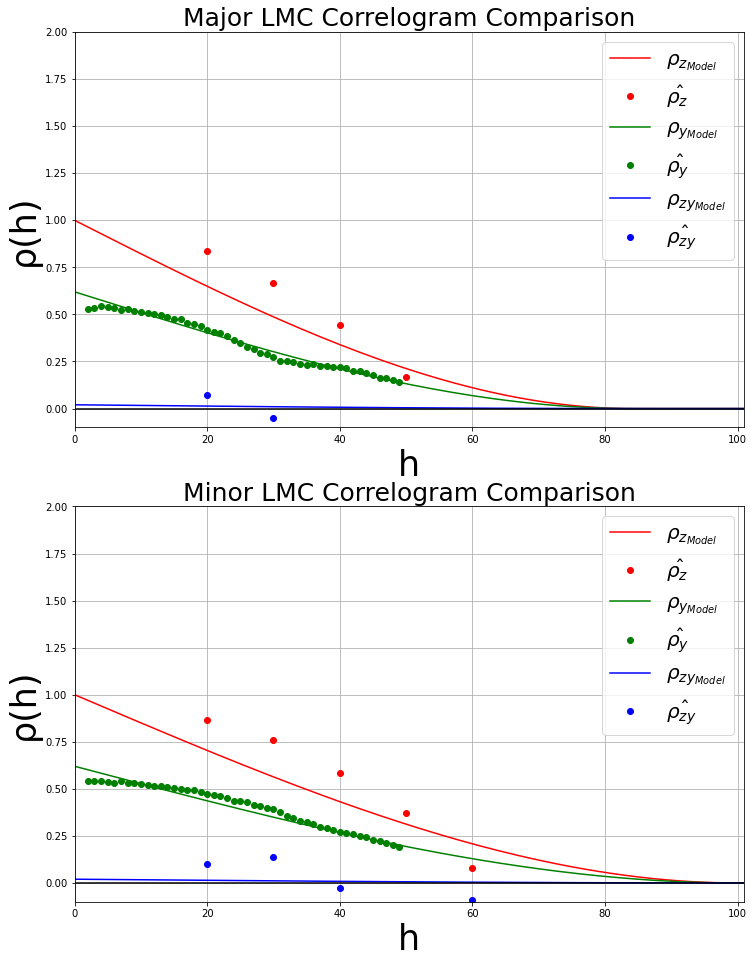

In [208]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{zy_{Model}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
nstruct = dict_secondary_LMC["nstruct"]
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary_LMC, nstruct )

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary_LMC, nstruct )

        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross_LMC, nstruct)

        H[h] = h
    MM_vargs = [cz_True, cy, czy]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" LMC Correlogram Comparison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

# Cokriging

In [210]:
Mean_Z = np.average(Primary["Primary"])
STD_Z = 1.0
print(Mean_Z)
print(STD_Z)

-1.9984014443252817e-17
1.0


In [211]:
Mean_Y = np.average(Primary["Secondary"])
STD_Y =  1.0
print(Mean_Y)
print(STD_Y)

-3.702593787124897e-16
1.0


## KDTree

In [212]:
from sklearn.neighbors import KDTree

In [213]:
def ech_data_kdtree(x,y,z,ech) :
    """
    Fonction qui ré-echantillonne avant l'utilisation d'un KD Tree
    """
    low_quality_secondary = pd.DataFrame()
    x_ech = x[::ech]
    low_quality_secondary["x"] = x_ech
    y_ech = y[::ech]
    low_quality_secondary["y"] = y_ech
    z_ech = z[::ech]
    low_quality_secondary["z"] = z_ech
    
    return low_quality_secondary,x_ech,y_ech,z_ech

In [214]:
##MATRICES NON ECHANTILLONEE
x = Secondary["X"].values
y = Secondary["Y"].values
z = Secondary["Secondary"].values

# MATRICES ECHANTILLONEES
ech = 1
df_kriging,x_ech,y_ech,z_ech = ech_data_kdtree(x,y,z,ech)

In [215]:
Primary.head()

,X,Y,original_z,original_zy,Primary,Secondary
0,0,0,-0.005196,0.389179,-0.869635,-0.422670
1,0,10,-0.011120,0.365244,-0.888949,-0.478681
2,0,20,0.104180,0.180827,-0.512981,-0.910236
3,0,30,-0.125674,0.078603,-1.262488,-1.149450
4,0,40,0.074539,0.512144,-0.609634,-0.134918


In [216]:
#Constitution d'un KD Tree, Primary data
datafl_XY = Primary[["X", "Y"]].values
datafl = Primary
tree = KDTree(datafl_XY)
Pred_grid_xy = np.matrix([x, y]).T

#Constitution d'un KD Tree, Secondary data
datafl_sec = Secondary
datafl_XY_2nd = Secondary[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

### Primary Data Search for Kriging

In [217]:
k_p = 60 # number of data to use
X_Y = np.zeros((len(x), k_p, 2))
X_Y_Star = np.zeros((len(x), k_p, 2))
closematrix_Primary = np.zeros((len(x), k_p))
closematrix_Secondary = np.zeros((len(x), k_p))
neardistmatrix = np.zeros((len(x), k_p))

for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["X", "Y"]]

### Secondary Data Search for Kriging

In [218]:
X_Y_2nd = np.zeros((len(x), k_p, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k_p))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k_p
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

### Recap des models de variogrammes

In [219]:
print("Premier Correlogram") 
print(dict_primary)

Premier Correlogram
{'a_max': [71.0], 'a_min': [86.0], 'cc': [1.46], 'vtype': array([1]), 'nstruct': 1}


In [220]:
print("Second Correlogram") 
print(dict_secondary)

Second Correlogram
{'a_max': [85.0], 'a_min': [109.0], 'cc': [0.61], 'vtype': array([1]), 'nstruct': 1}


In [221]:
print("Cross Correlogram") 
print(dict_cross)

Cross Correlogram
{'a_max': [29.0], 'a_min': [41.0], 'cc': [0.56], 'vtype': array([1]), 'nstruct': 1}


In [222]:
print("LMC Correlogram ") 
print(dict_LMC)

LMC Correlogram 
{'a_max': [84.0], 'a_min': [100.0], 'vtype': array([1]), 'nstruct': 1}


## Full Cokriging

In [223]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary, nstruct = 1, Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary, nstruct = 1, Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary, nstruct = 1, Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross, nstruct = 1, Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|█████████████████████████████████████████████████████████████████████████████| 5620/5620 [00:11<00:00, 493.65it/s]

There where 0 Singular Matrices


## Full Cokriging with LMC

In [224]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK_LMC = np.zeros(shape=(len(x)))
nstruct = 1

dict_secondary_LMC
dict_primary_LMC
dict_cross_LMC

for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary_LMC, nstruct ,Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary_LMC, nstruct ,Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary_LMC, nstruct ,Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross_LMC, nstruct ,Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK_LMC[z] = 0
    # add in mean_z
    est_Full_CCK_LMC[z] = est_Full_CCK_LMC[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|█████████████████████████████████████████████████████████████████████████████| 5620/5620 [00:11<00:00, 475.74it/s]

There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM2

In [225]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM2 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    # 1
    # C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
        
    cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0,corr,dict_secondary, dict_scalling )
    # C_ZY
    # 2,#3
    # corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    czy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # C_YY
    # 4
    # C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    cy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    # 5
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr,dict_secondary, dict_scalling )
    # RHS #C_yz*
    # 6
    r[k : k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # RHS corr
    # 7
    r[k * 2] = corr
    # c_zy
    # 8
    Kriging_Matrix[k * 2, 0:k] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # c_y
    # 9
    Kriging_Matrix[k * 2, k : k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k : k * 2, k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k * 2, k * 2] = 1
    # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM2[z] = 0
    # add in mean_z
    est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
    # add in the Y_0
    est_icck_MM2[z] = (
        est_icck_MM2[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|█████████████████████████████████████████████████████████████████████████████| 5620/5620 [00:16<00:00, 348.57it/s]

There where 0 Singular Matrices


##  Mise en place des résultats

In [30]:
ktypes = ["SCK","LMC_SCK","ICC_MM2"]
k_est = [est_Full_CCK,
         est_Full_CCK_LMC,
         est_icck_MM2
]
ktypes_vals_dict = {}
dict_types = {}
j = 0
for i in ktypes:
    
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
    }
    
    df_kriging["NS_Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]
    df_kriging["Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]* original_std_z + original_mean_z
    j = j + 1

NameError: name 'est_Full_CCK' is not defined

##  Affichage des différents cokrigeage

### MM2 vs SCK

Text(0.5, 1.0, 'SCK\nZ : 1.46 Spherical \nY : 0.61 Spherical \nZY : 0.56 Spherical \n')

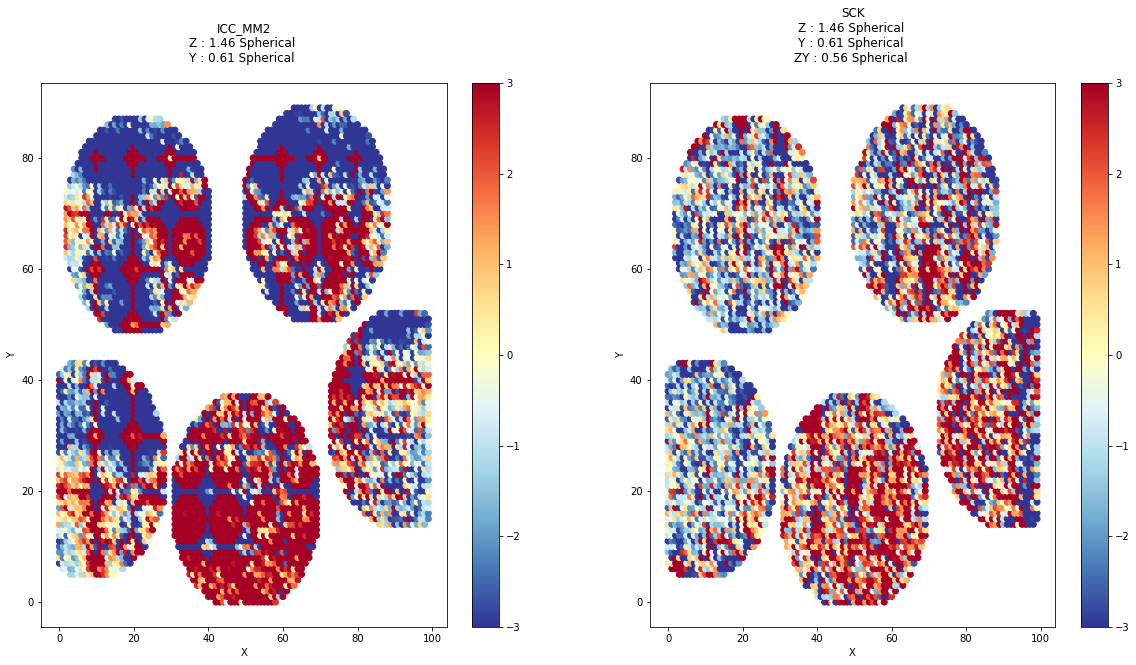

In [227]:
fig,ax=plt.subplots(1,2, figsize = (20,10))

types = "ICC_MM2"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[0].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
# Title name Z / Y 
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax[0].set_title(types +'\n'+TITLE)
fig.colorbar(img0, ax=ax[0])

# ----------------------------------------------------------------------------------------------------------
types = "SCK"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[1].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
fig.colorbar(img0, ax=ax[1])

# Title name Z / Y / ZY
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross["cc"])<2 or count == len(dict_cross["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax[1].set_title(types +'\n'+TITLE)

### LMC

Text(0.5, 1.0, 'LMC_SCK\nZ : 1.0 Spherical \nY : 0.62 Spherical \nZY : 0.02 Spherical \n')

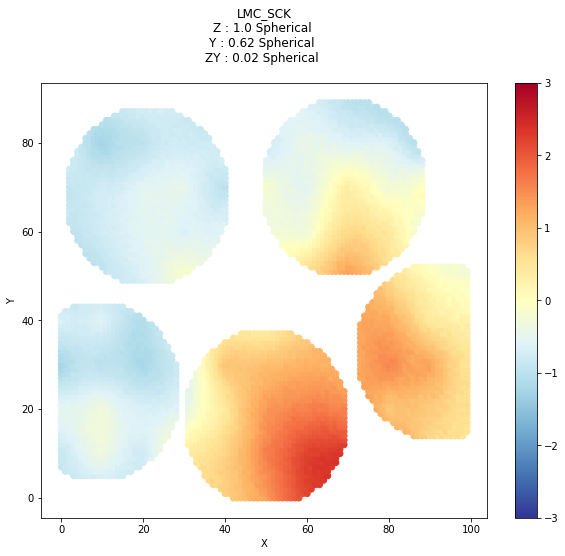

In [228]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (10,8))
types = "LMC_SCK"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(img0, ax=ax)

# Title name Z / Y / ZY
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary_LMC["cc"],dict_primary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary_LMC["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary_LMC["cc"])<2 or count == len(dict_primary_LMC["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary_LMC["cc"],dict_secondary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary_LMC["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary_LMC["cc"])<2) or (count == len(dict_secondary_LMC["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross_LMC["cc"],dict_cross_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross_LMC["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross_LMC["cc"])<2 or count == len(dict_cross_LMC["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax.set_title(types +'\n'+TITLE)

#  Comparaison des Cokriging à la fonction initiale 

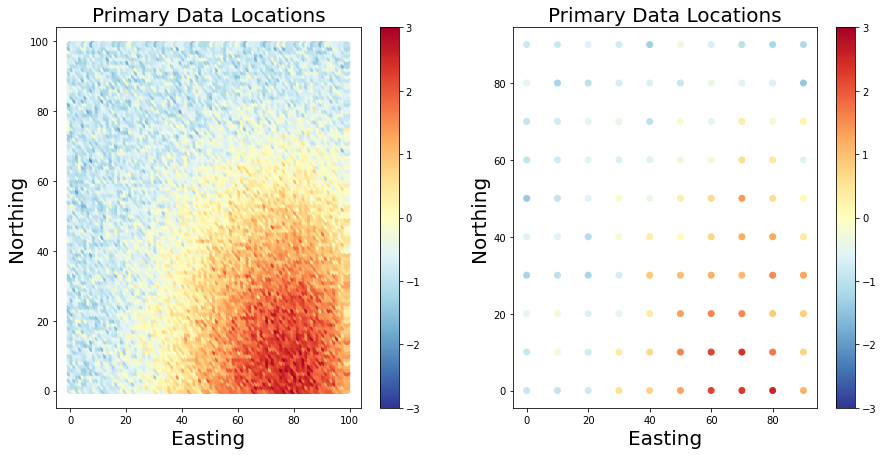

In [229]:
#Primary_truth Data Data
x, y = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
np.random.seed(21)
mu, sigma = 0, 0.1
_field_z_truth  = fun_Primary(x,y,mu,sigma,size = 100)

Primary_truth = pd.DataFrame()
Primary_truth["X"] = xx_y.reshape(-1)
Primary_truth["Y"] = yy_y.reshape(-1)
Primary_truth["original_z"] = _field_z_truth.reshape(-1)
Primary_truth["Primary"] = (Primary_truth["original_z"] - Primary_truth["original_z"].mean()) / Primary_truth["original_z"].std()

f, ax = plt.subplots(1,2, figsize = (15,7))

img0 = ax[0].scatter(Primary_truth["X"], Primary_truth["Y"], c=Primary_truth["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)
fig.colorbar(img0, ax=ax[0])

img0 = ax[1].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_title("Primary Data Locations", size=20)
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
fig.colorbar(img0, ax=ax[1])


### Différence entre LMC / fonction initiale

NameError: name 'df_kriging' is not defined

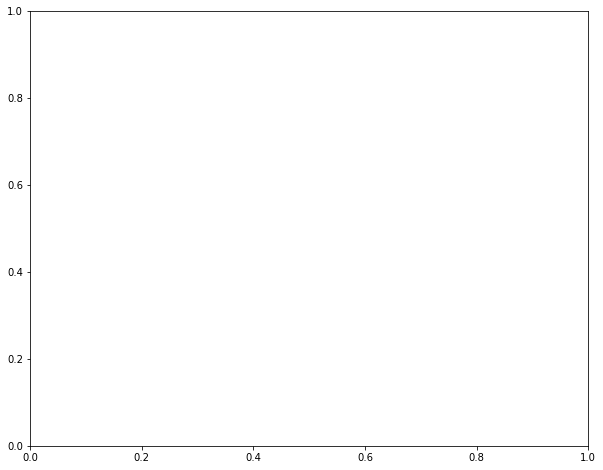

In [29]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (10,8))
types = "LMC_SCK"
#Différence entre les valeurs originales et non transformées
Z_ck = df_kriging["Estimate_"+types].values 
Z_truth = Primary_truth["original_z"].values
Z = Z_truth - Z_ck
RMSE = np.sqrt(mean_squared_error(Z_ck,Z_truth))
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -1, vmax = 1, cmap = "seismic")
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(img0, ax=ax)
Title = "Différence entre les valeurs issus d'un cokriging LMC et de la fonction initiale \n RMSE = " + "{:.2f}".format(RMSE)
ax.set_title(Title)